## PGP related Experiments

### Imports and preprocessings

In [1]:
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.metrics import r2_score, accuracy_score

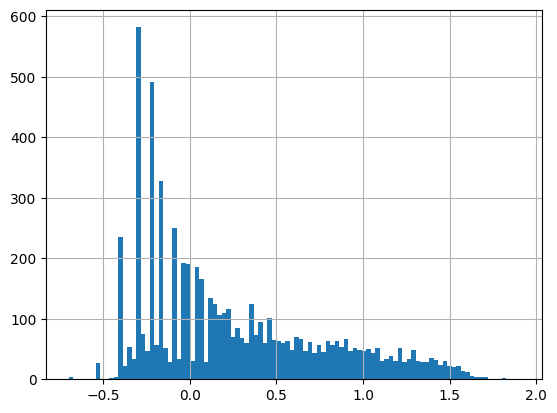

In [3]:
# it seems that the distribution of the two datasets are different:
# using cross-validation inside the train dataset will result in ~0.32 R^2, and the number if ~-0.1 for test dataset.
# Therefore, I will try only using train dataset for now.

train = pd.read_csv("data\\PGP_training_disguised.csv")
# test = pd.read_csv("data\\PGP_test_disguised.csv")

train['Act'].hist(bins=100)

# need to reindex the test dataset for fitting and predicting
# test = test.reindex(columns=train.columns, fill_value=0)
# test.describe()

n = len(train)
perm = np.random.permutation(n)
test = train.iloc[perm[:int(0.1 * n)]]
calib = train.iloc[perm[int(0.1 * n):int(0.3 * n)]]
train = train.iloc[perm[int(0.3 * n):]]

In [4]:
len(train), len(calib), len(test)

(4480, 1280, 639)

In [5]:
train.head(5)

,MOLECULE,Act,D_8,D_36,D_37,D_38,D_39,D_40,D_41,D_42,...,D_10879,D_10880,D_10881,D_10883,D_10884,D_10974,D_10975,D_10976,D_10993,D_10994
5585,M_125339,-0.2663,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
290,M_44923,0.4623,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4712,M_111871,-0.0969,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1784,M_80373,-0.2218,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1893,M_81312,0.3424,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
train.describe()
# not all descriptors are binary

,Act,D_8,D_36,D_37,D_38,D_39,D_40,D_41,D_42,D_43,...,D_10879,D_10880,D_10881,D_10883,D_10884,D_10974,D_10975,D_10976,D_10993,D_10994
count,4480.000000,4480.000000,4480.000000,4480.000000,4480.000000,4480.000000,4480.000000,4480.000000,4480.000000,4480.000000,...,4480.000000,4480.000000,4480.000000,4480.000000,4480.000000,4480.000000,4480.000000,4480.000000,4480.000000,4480.000000
mean,0.254781,0.000223,0.000670,0.000446,0.000446,0.000893,0.012277,0.003795,0.002455,0.002902,...,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223
std,0.527835,0.014940,0.025872,0.021126,0.021126,0.029871,0.185621,0.090810,0.049496,0.080413,...,0.014940,0.014940,0.014940,0.014940,0.014940,0.014940,0.014940,0.014940,0.014940,0.014940
min,-0.681900,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-0.194000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.113900,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.609850,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.811900,1.000000,1.000000,1.000000,1.000000,1.000000,5.000000,3.000000,1.000000,3.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


<Axes: >

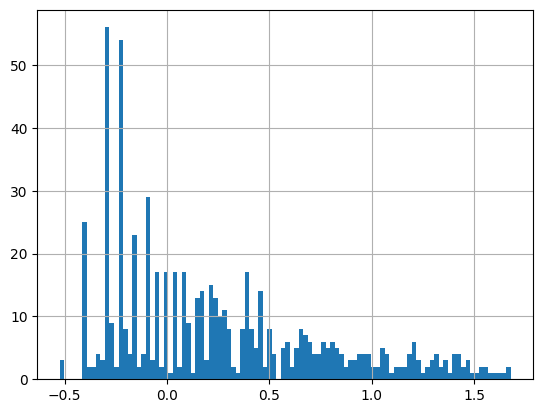

In [5]:
test['Act'].hist(bins=100)

### Experiments (Simulation)

##### FDR control graph for varying nominal levels

In [2]:
from utility import BH, Bonferroni, SingleSel, RegionSel, gen_data

# threshold = {1: -2.3, 2: 0.1, 5: -0.43, 6: -1.5}  # lower 15% quantile
threshold = {1: 2.3, 2: 4.0, 5: 0.43, 6: 0.6}   # higher 15% quantile

def run(setting, q, select_lower=False):
    Xtrain, Ytrain, _ = gen_data(setting=setting, n=1000, sig=0.3)
    Xcalib, Ycalib, _ = gen_data(setting=setting, n=1000, sig=0.3)
    Xtest, Ytest, _ = gen_data(setting=setting, n=1000, sig=0.3)

    # if select_lower:
    #     threshold = {1: -2.3, 2: 0.1, 5: -0.43, 6: -1.5}  # lower 15% quantile
    #     lower = -100
    #     higher = threshold[setting]
    # else:
    #     threshold = {1: 2.3, 2: 4.0, 5: 0.43, 6: 0.6}   # higher 15% quantile
    #     lower = threshold[setting]
    #     higher = 100
    lower = 0
    higher = 100

    Ytest_orig = Ytest

    Ytrain = 1 * ((lower < Ytrain) & (Ytrain < higher))
    Ycalib = 1 * ((lower < Ycalib) & (Ycalib < higher))
    Ytest = 1 * ((lower < Ytest) & (Ytest < higher))

    rf = RandomForestRegressor(n_estimators=100, max_depth=20, max_features='sqrt')
    rf.fit(Xtrain, Ytrain)

    r_sq = r2_score(Ytest, rf.predict(Xtest))

    calib_scores = Ycalib - rf.predict(Xcalib)          
    calib_scores0 = -rf.predict(Xcalib)                     
    calib_scores_2clip = 1000 * (Ycalib > 0) - rf.predict(Xcalib)   # Ycalib > 0.5 <=> original Ycalib < threshold

    test_scores = -rf.predict(Xtest)

    # selection target is 
    true_reject = sum(Ytest > 0) 
    BH_2clip = BH(calib_scores_2clip, test_scores, q )
    # Single = SingleSel(calib_scores_2clip, test_scores, q )
    Single = RegionSel(calib_scores, test_scores, q )
    
    rest = [i for i in Single if i not in BH_2clip]
    return Ytest, Single, BH_2clip

def eval(Y, rejected, lower, higher):
    true_reject = np.sum((lower < Y) & (Y < higher))
    if len(rejected) == 0:
        fdp = 0
        pcer = 0
        power = 0
    else:
        fdp = np.sum((lower >= Y[rejected]) | (Y[rejected] >= higher)) / len(rejected)
        pcer = np.sum((lower >= Y[rejected]) | (Y[rejected] >= higher)) / len(Y)
        power = np.sum((lower < Y[rejected]) & (Y[rejected] < higher)) / true_reject if true_reject != 0 else 0
    return fdp, pcer, power

In [3]:
import numpy as np
from tqdm import tqdm

def run_and_plot(setting, itr=100):
    q_list = np.linspace(0.01, 0.3, 30)
    s_fdps, s_pcers, s_powers = [], [], []
    b_fdps, b_pcers, b_powers = [], [], []

    for q in tqdm(q_list):
        avg_s_fdp, avg_s_pcer, avg_s_power = 0, 0, 0
        avg_b_fdp, avg_b_pcer, avg_b_power = 0, 0, 0

        for k in range(itr):
            Y, single, bh = run(1, q, select_lower=False)
            s_fdp, s_pcer, s_power = eval(Y, single, 0, 100)
            b_fdp, b_pcer, b_power = eval(Y, bh, 0, 100)

            avg_s_fdp += s_fdp / itr
            avg_s_pcer += s_pcer / itr
            avg_s_power += s_power / itr
            avg_b_fdp += b_fdp / itr
            avg_b_pcer += b_pcer / itr
            avg_b_power += b_power / itr
        s_fdps.append(avg_s_fdp)
        s_pcers.append(avg_s_pcer)
        s_powers.append(avg_s_power)
        b_fdps.append(avg_b_fdp)
        b_pcers.append(avg_b_pcer)
        b_powers.append(avg_b_power)
    fig, axs = plt.subplots(figsize=(12, 8))
    axs.plot(1 - q_list, s_fdps, marker='o', label='fdp')
    axs.plot(1 - q_list, s_pcers, marker='o', label='pcer')
    axs.plot([0.7, 1], [0.3, 0], linestyle='-.', alpha=0.5)
    axs.set_title("PCER vs FDP plot for varying nominal levels")
    axs.set_xlabel("Nominal confidence levels")
    axs.set_ylabel("Realized values")
    fig.legend()
    plt.show()

100%|██████████| 30/30 [14:50<00:00, 29.68s/it]


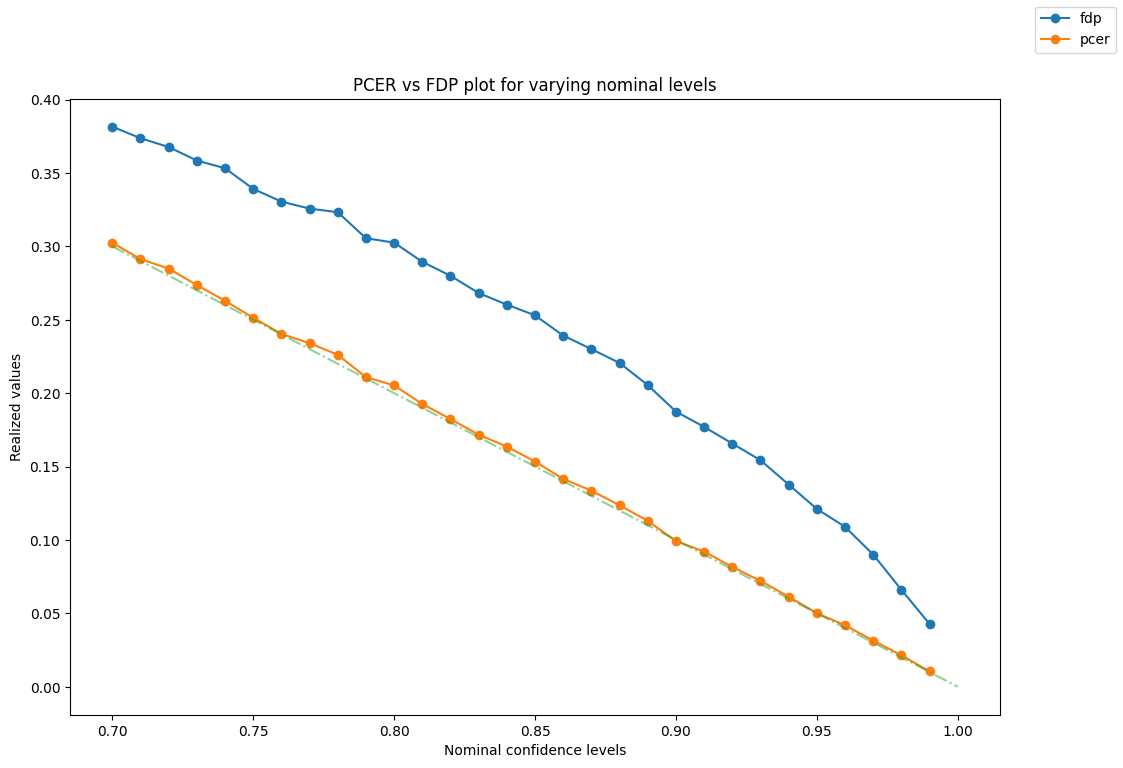

In [5]:
run_and_plot(1, itr=100)

##### Bonferroni FDR and Power graph for varying nominal levels

In [18]:
from utility import BH, Bonferroni, SingleSel, RegionSel, gen_data

def run(setting, q, select_lower=False):
    Xtrain, Ytrain, _ = gen_data(setting=setting, n=1000, sig=0.3)
    Xcalib, Ycalib, _ = gen_data(setting=setting, n=1000, sig=0.3)
    Xtest, Ytest, _ = gen_data(setting=setting, n=1000, sig=0.3)

    lower = 0
    higher = 100

    Ytest_orig = Ytest

    Ytrain = 1 * ((lower < Ytrain) & (Ytrain < higher))
    Ycalib = 1 * ((lower < Ycalib) & (Ycalib < higher))
    Ytest = 1 * ((lower < Ytest) & (Ytest < higher))

    rf = RandomForestRegressor(n_estimators=100, max_depth=20, max_features='sqrt')
    rf.fit(Xtrain, Ytrain)

    r_sq = r2_score(Ytest, rf.predict(Xtest))

    calib_scores = Ycalib - rf.predict(Xcalib)          
    calib_scores0 = -rf.predict(Xcalib)                     
    calib_scores_2clip = 1000 * (Ycalib > 0) - rf.predict(Xcalib)   # Ycalib > 0.5 <=> original Ycalib < threshold

    test_scores = -rf.predict(Xtest)

    # selection target is 
    true_reject = sum(Ytest > 0) 
    BH_2clip = BH(calib_scores_2clip, test_scores, q )
    # Single = SingleSel(calib_scores_2clip, test_scores, q )
    bonf = Bonferroni(calib_scores, test_scores, q )
    
    return Ytest, bonf, BH_2clip

def eval(Y, rejected, lower, higher):
    true_reject = np.sum((lower < Y) & (Y < higher))
    if len(rejected) == 0:
        fdp = 0
        pcer = 0
        power = 0
    else:
        fdp = np.sum((lower >= Y[rejected]) | (Y[rejected] >= higher)) / len(rejected)
        pcer = np.sum((lower >= Y[rejected]) | (Y[rejected] >= higher)) / len(Y)
        power = np.sum((lower < Y[rejected]) & (Y[rejected] < higher)) / true_reject if true_reject != 0 else 0
    return fdp, pcer, power

In [36]:
import numpy as np
from tqdm import tqdm

def run_and_plot(setting, itr=100):
    q_list = np.linspace(0.1, 0.5, 20)
    s_fdps, s_pcers, s_powers = [], [], []
    b_fdps, b_pcers, b_powers = [], [], []

    for q in tqdm(q_list):
        avg_s_fdp, avg_s_pcer, avg_s_power = 0, 0, 0
        avg_b_fdp, avg_b_pcer, avg_b_power = 0, 0, 0

        for k in range(itr):
            Y, bonf, bh = run(1, q, select_lower=False)
            s_fdp, s_pcer, s_power = eval(Y, bonf, 0, 100)
            b_fdp, b_pcer, b_power = eval(Y, bh, 0, 100)

            avg_s_fdp += s_fdp / itr
            avg_s_pcer += s_pcer / itr
            avg_s_power += s_power / itr
            avg_b_fdp += b_fdp / itr
            avg_b_pcer += b_pcer / itr
            avg_b_power += b_power / itr
        s_fdps.append(avg_s_fdp)
        s_pcers.append(avg_s_pcer)
        s_powers.append(avg_s_power)
        b_fdps.append(avg_b_fdp)
        b_pcers.append(avg_b_pcer)
        b_powers.append(avg_b_power)
    fig, axs = plt.subplots(figsize=(12, 8))
    axs.plot(q_list, s_fdps, marker='o', label='Bonferroni')
    axs.plot(q_list, b_fdps, marker='o', label='BH')
    axs.plot([0.1, 0.5], [0.1, 0.5], linestyle='-.', alpha=0.5)
    axs2 = axs.twinx()
    axs2.bar(q_list, s_powers, width=0.005, alpha=0.4)
    axs2.bar(q_list + 0.005, b_powers, width=0.005, alpha=0.4)
    axs2.set_ylabel("Power")
    axs.set_title("FDP and Power comparison for Bonferroni and BH")
    axs.set_xlabel("FDR target")
    axs.set_ylabel("Realized FDR")
    fig.legend()
    plt.show()

100%|██████████| 20/20 [10:36<00:00, 31.80s/it]


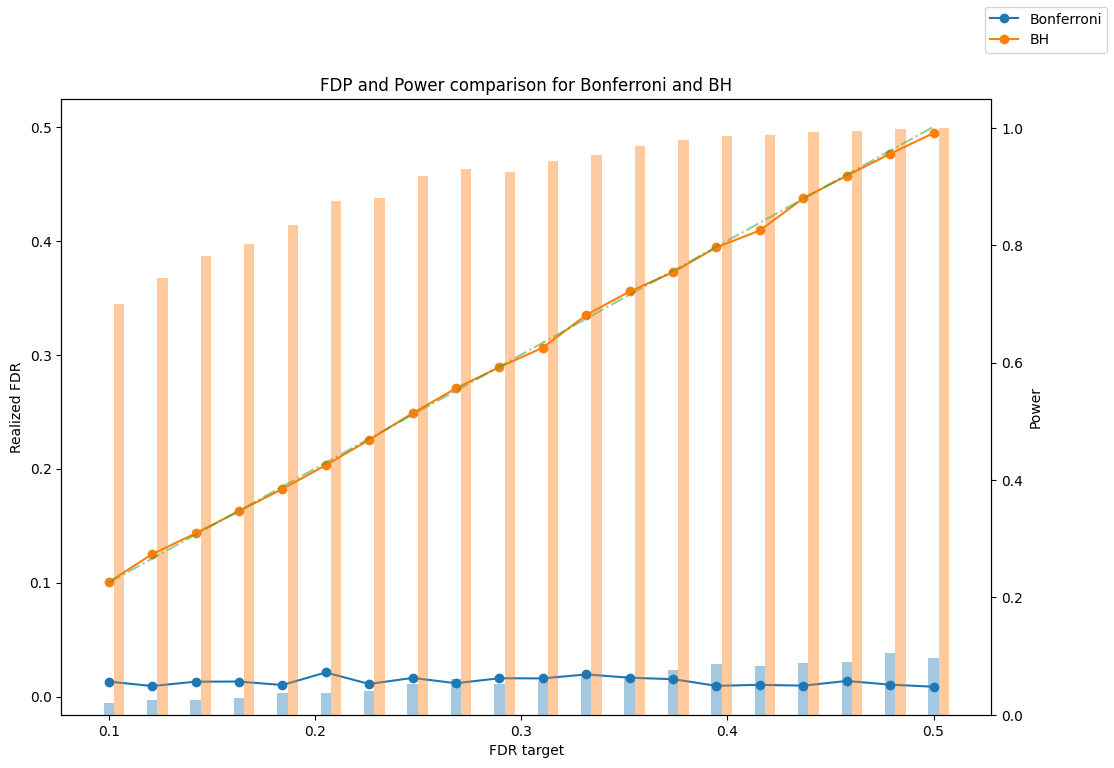

In [37]:
run_and_plot(1, 100)

##### Plot the distribution comparison graph

In [288]:
from utility import BH, Bonferroni, SingleSel, gen_data

# threshold = {1: -2.3, 2: 0.1, 5: -0.43, 6: -1.5}  # lower 15% quantile
threshold = {1: 2.3, 2: 4.0, 5: 0.43, 6: 0.6}   # higher 15% quantile

def run(setting, q, select_lower=False):
    Xtrain, Ytrain, _ = gen_data(setting=setting, n=1000, sig=0.3)
    Xcalib, Ycalib, _ = gen_data(setting=setting, n=1000, sig=0.3)
    Xtest, Ytest, _ = gen_data(setting=setting, n=1000, sig=0.3)

    if select_lower:
        threshold = {1: -2.3, 2: 0.1, 5: -0.43, 6: -1.5}  # lower 15% quantile
        lower = -100
        higher = threshold[setting]
    else:
        threshold = {1: 2.3, 2: 4.0, 5: 0.43, 6: 0.6}   # higher 15% quantile
        lower = threshold[setting]
        higher = 100

    Ytest_orig = Ytest

    Ytrain = 1 * ((lower < Ytrain) & (Ytrain < higher))
    Ycalib = 1 * ((lower < Ycalib) & (Ycalib < higher))
    Ytest = 1 * ((lower < Ytest) & (Ytest < higher))

    rf = RandomForestRegressor(n_estimators=100, max_depth=20, max_features='sqrt')
    rf.fit(Xtrain, Ytrain)

    r_sq = r2_score(Ytest, rf.predict(Xtest))

    calib_scores = Ycalib - rf.predict(Xcalib)          
    calib_scores0 = -rf.predict(Xcalib)                     
    calib_scores_2clip = 1000 * (Ycalib > 0) - rf.predict(Xcalib)   # Ycalib > 0.5 <=> original Ycalib < threshold

    test_scores = -rf.predict(Xtest)

    # selection target is 
    true_reject = sum(Ytest > 0) 
    BH_2clip = BH(calib_scores_2clip, test_scores, q )
    Single = SingleSel(calib_scores_2clip, test_scores, q )
    
    rest = [i for i in Single if i not in BH_2clip]
    return Ytest_orig, BH_2clip, rest

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:32<00:00,  3.12it/s]


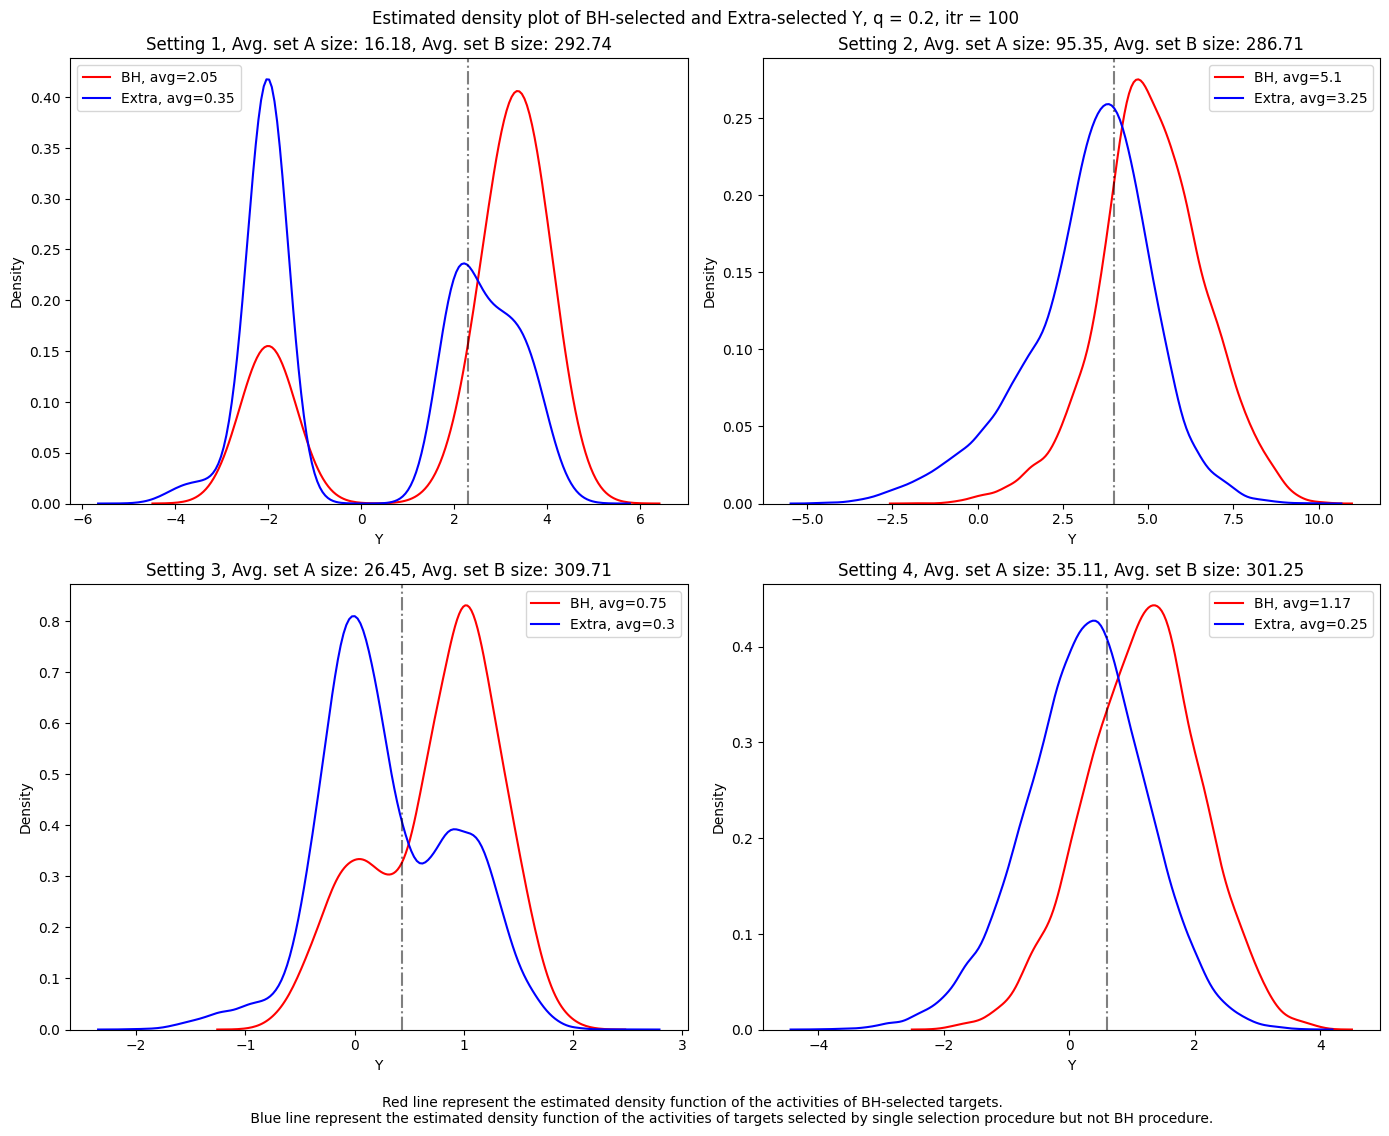

In [294]:
import seaborn as sb
from tqdm import tqdm

def run_and_plot(q, sel_lower, itr=100):
    if sel_lower:
        threshold = {1: -2.3, 2: 0.1, 5: -0.43, 6: -1.5}  # lower 15% quantile
    else:
        threshold = {1: 2.3, 2: 4.0, 5: 0.43, 6: 0.6}   # higher 15% quantile

    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(14, 11))

    for i, setting in enumerate([1, 2, 5, 6]):
        x = i // 2
        y = i % 2
        BH_2clip_values = []
        rest_values = []
        bh_sizes = 0
        rest_sizes = 0

        for k in tqdm(range(itr)):
            Ytest_orig, bh, rest = run(setting=setting, q=q, select_lower=sel_lower)
            bh_sizes += len(bh)
            rest_sizes += len(rest)
            if len(bh):
                BH_2clip_values.extend(Ytest_orig[bh])
            if len(rest):
                rest_values.extend(Ytest_orig[rest])
        bh_sizes /= itr
        rest_sizes /= itr

        sb.kdeplot(BH_2clip_values, color='red', ax=axs[x][y])
        sb.kdeplot(rest_values, color='blue', ax=axs[x][y])
        axs[x][y].axvline(threshold[setting], color='black', linestyle='-.', alpha=0.5)
        axs[x][y].set_xlabel('Y')
        axs[x][y].legend(labels=[f'BH, avg={round(np.mean(BH_2clip_values), 2)}', f'Extra, avg={round(np.mean(rest_values), 2)}'])
        axs[x][y].set_title(f"Setting {i+1}, Avg. set A size: {round(bh_sizes, 2)}, Avg. set B size: {round(rest_sizes, 2)}")

    fig.suptitle(f"Estimated density plot of BH-selected and Extra-selected Y, q = {q}, itr = {itr}")
    fig.text(0.5, -0.03, "Red line represent the estimated density function of the activities of BH-selected targets. \n \
                Blue line represent the estimated density function of the activities of targets selected by single selection procedure but not BH procedure.",
                wrap=True, horizontalalignment='center')
    plt.tight_layout()
    plt.show()

run_and_plot(0.2, False, 100)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:31<00:00,  3.19it/s]


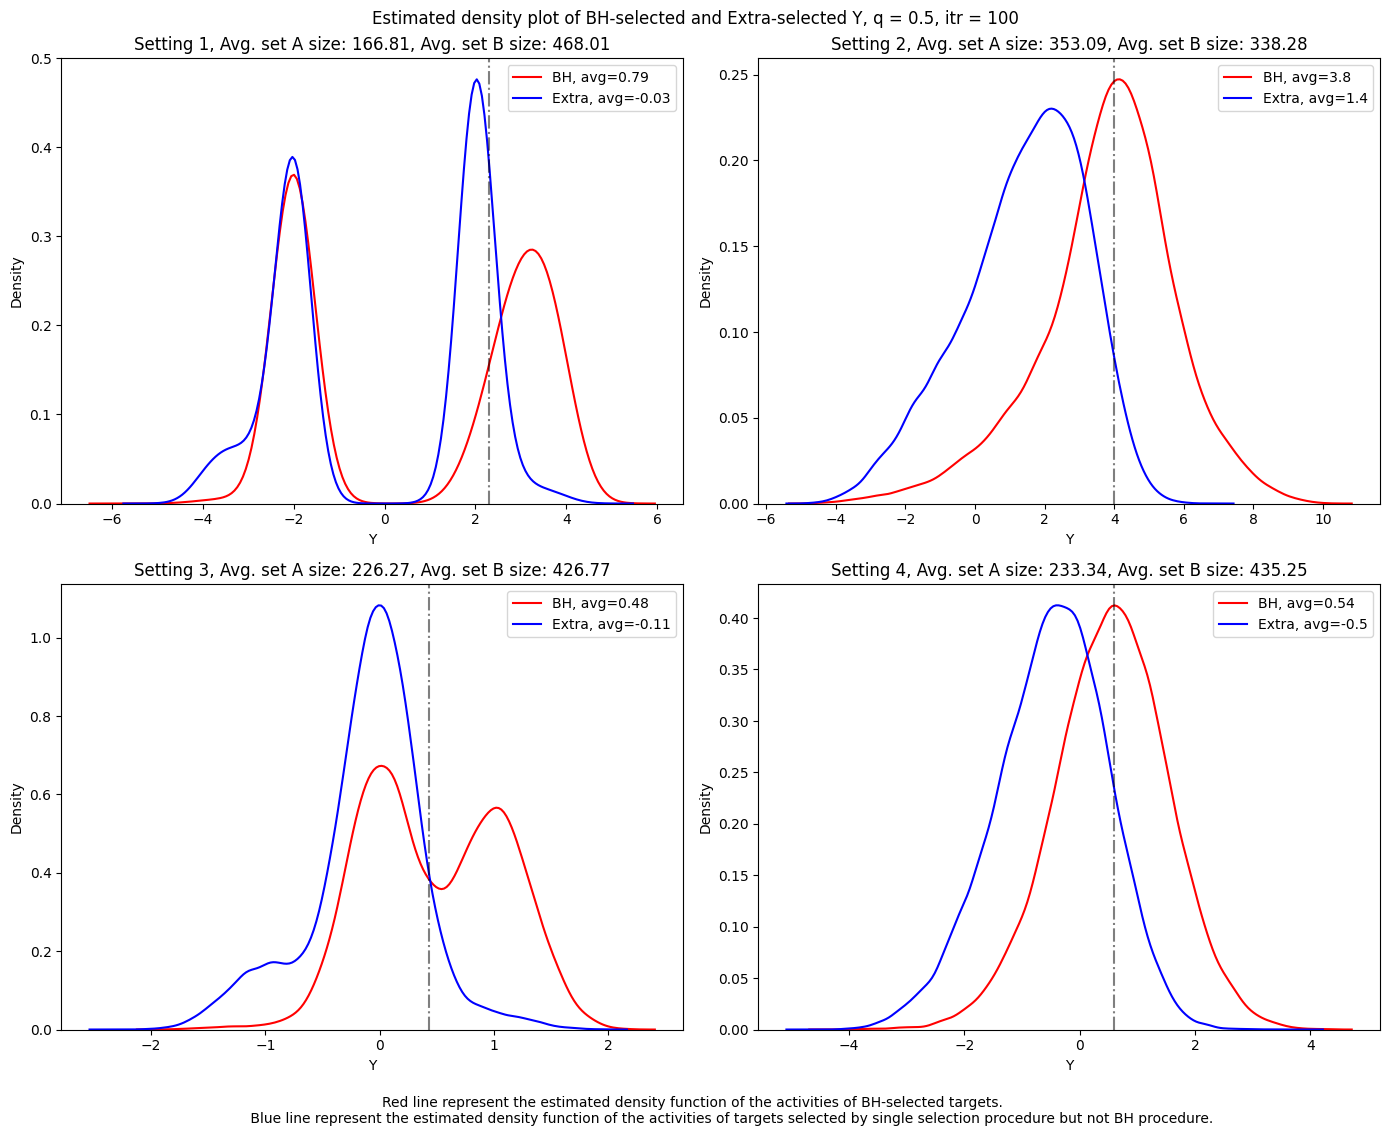

In [295]:
run_and_plot(0.5, False, 100)

##### Plot the selection tradeoff graph

In [296]:
from utility import BH, Bonferroni, SingleSel

def run(setting, q, select_lower=False):
    Xtrain, Ytrain, _ = gen_data(setting=setting, n=1000, sig=0.3)
    Xcalib, Ycalib, _ = gen_data(setting=setting, n=1000, sig=0.3)
    Xtest, Ytest, _ = gen_data(setting=setting, n=1000, sig=0.3)

    if select_lower:
        threshold = {1: -2.3, 2: 0.1, 5: -0.43, 6: -1.5}  # lower 15% quantile
        lower = -100
        higher = threshold[setting]
    else:
        threshold = {1: 2.3, 2: 4.0, 5: 0.43, 6: 0.6}   # higher 15% quantile
        lower = threshold[setting]
        higher = 100

    Ytest_orig = Ytest

    Ytrain = 1 * ((lower < Ytrain) & (Ytrain < higher))
    Ycalib = 1 * ((lower < Ycalib) & (Ycalib < higher))
    Ytest = 1 * ((lower < Ytest) & (Ytest < higher))

    rf = RandomForestRegressor(n_estimators=100, max_depth=20, max_features='sqrt')
    rf.fit(Xtrain, Ytrain)

    r_sq = r2_score(Ytest, rf.predict(Xtest))

    calib_scores = Ycalib - rf.predict(Xcalib)          
    calib_scores0 = -rf.predict(Xcalib)                     
    calib_scores_2clip = 1000 * (Ycalib > 0) - rf.predict(Xcalib)   # Ycalib > 0.5 <=> original Ycalib < threshold

    test_scores = -rf.predict(Xtest)

    # selection target is 
    true_reject = sum(Ytest > 0) 
        
    # use clipped scores
    BH_2clip = BH(calib_scores_2clip, test_scores, q, )
    Single = SingleSel(calib_scores_2clip, test_scores, q, )
    
    # if BH_2clip is sorted and Single is sorted, then rest is also sorted based on p-values
    rest = [i for i in Single if i not in BH_2clip]
    
    # start with selecting all BH-selected samples
    selected = BH_2clip
    if len(selected):
        false_sel = np.sum(Ytest[selected] <= 0)
        true_sel = np.sum(Ytest[selected] > 0)
    else:
        false_sel = 0
        true_sel = 0
    nsel = len(selected)

    powers = [true_sel / true_reject if true_reject else 0]
    fdps = [false_sel / nsel if nsel else 0]
    miscoverages = [false_sel / len(Ytest)]

    # now gradually increase the selected samples, and see how power/fdp changes.
    for i in rest:
        nsel += 1
        if Ytest[i] > 0: # another good sel
            true_sel += 1
        else:
            false_sel += 1
        powers.append(true_sel / true_reject if true_reject else 0)
        fdps.append(false_sel / nsel if nsel else 0)
        miscoverages.append(false_sel / len(Ytest))

    return powers, fdps, miscoverages, len(BH_2clip), len(Single)

def experiment(setting, q, select_lower=False, itr=100):
    base_power = 0
    base_fdp = 0
    base_misc = 0

    largest_diff = 0
    power_incr = np.zeros(1000)
    fdp_incr = np.zeros(1000)
    misc_incr = np.zeros(1000)

    bh_lens = 0
    single_lens = 0

    for k in tqdm(range(itr)):
        powers, fdps, misc, bh_len, single_len = run(setting, q, select_lower)
        bh_lens += bh_len
        single_lens += single_len
        base_power += powers[0]
        base_fdp += fdps[0]
        base_misc += misc[0]

        largest_diff = max(largest_diff, len(fdps))
        for i in range(len(powers) - 1):
            power_incr[i] += powers[i+1] - powers[i]
            fdp_incr[i] += fdps[i+1] - fdps[i]
            misc_incr[i] += misc[i+1] - misc[i]

    bh_lens /= itr
    single_lens /= itr
    power_incr /= itr
    fdp_incr /= itr
    misc_incr /= itr
    base_power /= itr
    base_fdp /= itr
    base_misc /= itr

    powers = np.zeros(largest_diff+1)
    fdps = np.zeros(largest_diff+1)
    misc = np.zeros(largest_diff+1)
    powers[0] = base_power
    fdps[0] = base_fdp
    misc[0] = base_misc
    for i in range(1, largest_diff+1):
        powers[i] = powers[i-1] + power_incr[i-1]
        fdps[i] = fdps[i-1] + fdp_incr[i-1]
        misc[i] = misc[i-1] + misc_incr[i-1]

    return powers, fdps, misc, single_lens, bh_lens

100%|██████████| 100/100 [00:34<00:00,  2.93it/s]


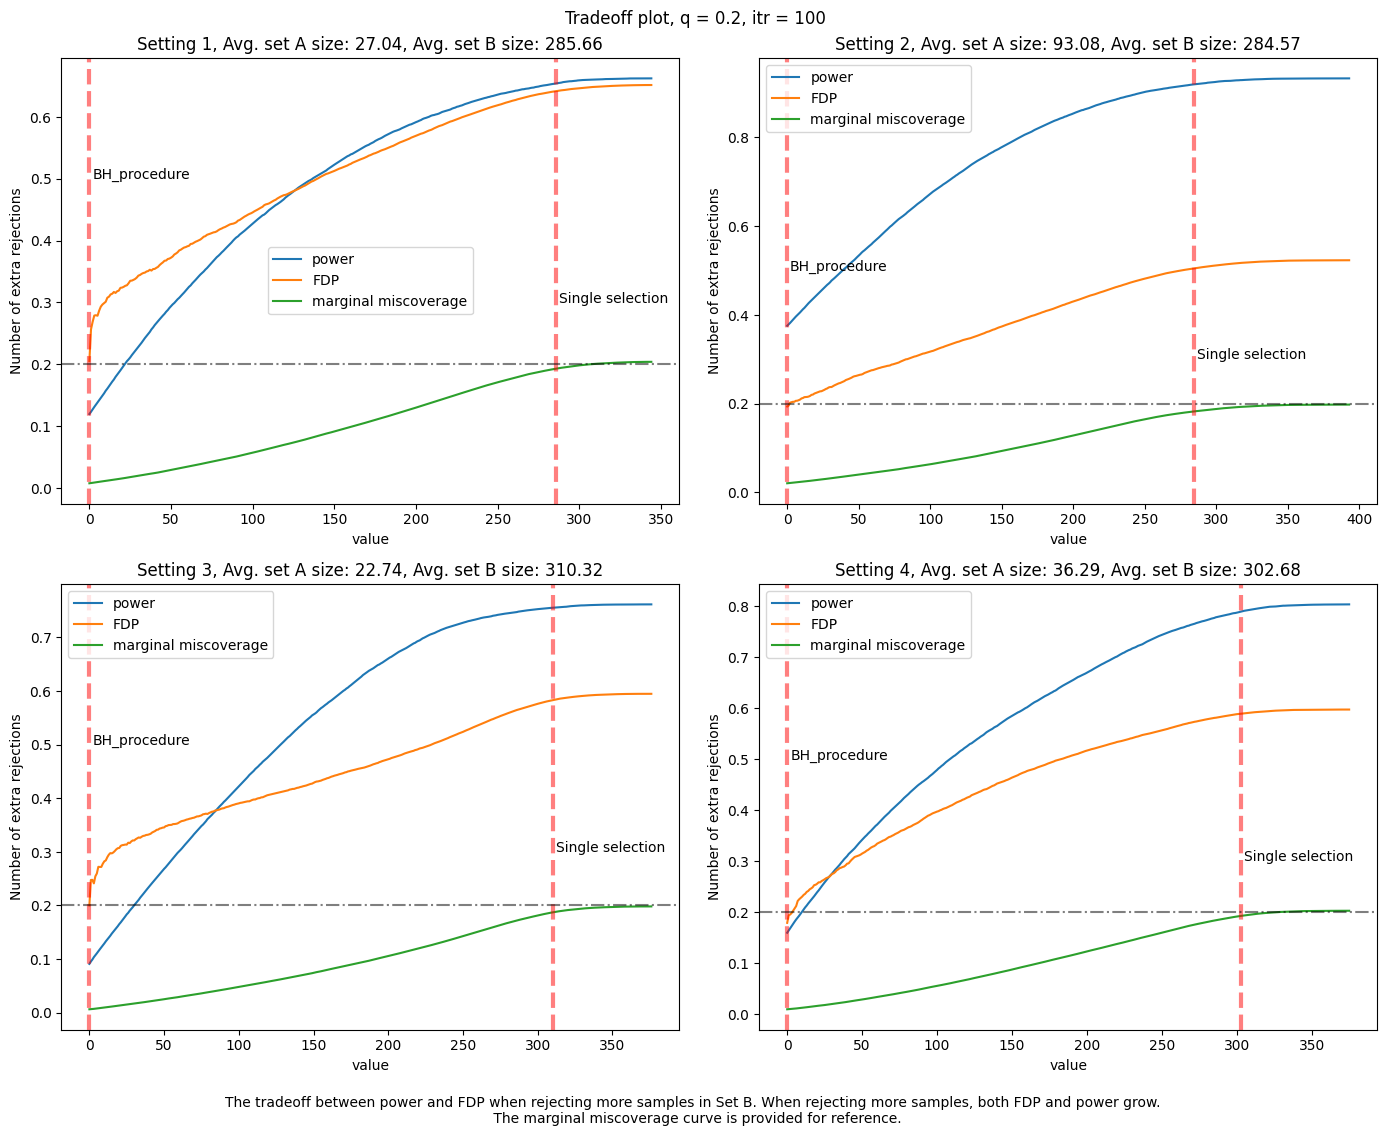

In [297]:
def run_and_plot(q, select_lower, itr=100):
    fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(14, 11))

    for i, setting in enumerate([1, 2, 5, 6]):
        x = i // 2
        y = i % 2

        powers, fdps, misc, single_lens, bh_lens = experiment(setting=setting, q=q, select_lower=False, itr=itr)

        axs[x][y].plot(powers, label='power')
        axs[x][y].plot(fdps, label='FDP')
        axs[x][y].plot(misc, label='marginal miscoverage')
        axs[x][y].axvline((single_lens - bh_lens), linestyle='--', color='red', alpha=0.5, linewidth=3)
        axs[x][y].axvline(0, linestyle='--', color='red', alpha=0.5, linewidth=3)
        axs[x][y].axhline(q, linestyle='-.', alpha=0.5, color='black')
        axs[x][y].set_title(f"Setting {i+1}, Avg. set A size: {round(bh_lens, 2)}, Avg. set B size: {round(single_lens - bh_lens, 2)}")
        axs[x][y].set_xlabel('value')
        axs[x][y].set_ylabel('Number of extra rejections')
        axs[x][y].text(2, 0.6, "BH_procedure")
        axs[x][y].text((single_lens - bh_lens) + 2, 0.3, 'Single selection')
        axs[x][y].legend()

    fig.suptitle(f'Tradeoff plot, q = {q}, itr = {itr}')
    fig.text(0.5, -0.03, "The tradeoff between power and FDP when rejecting more samples in Set B. When rejecting more samples, both FDP and power grow. \n The marginal miscoverage curve is provided for reference.",
            wrap=True, horizontalalignment='center')
    plt.tight_layout()
    plt.show()

run_and_plot(0.2, False, 100)

100%|██████████| 100/100 [00:34<00:00,  2.89it/s]


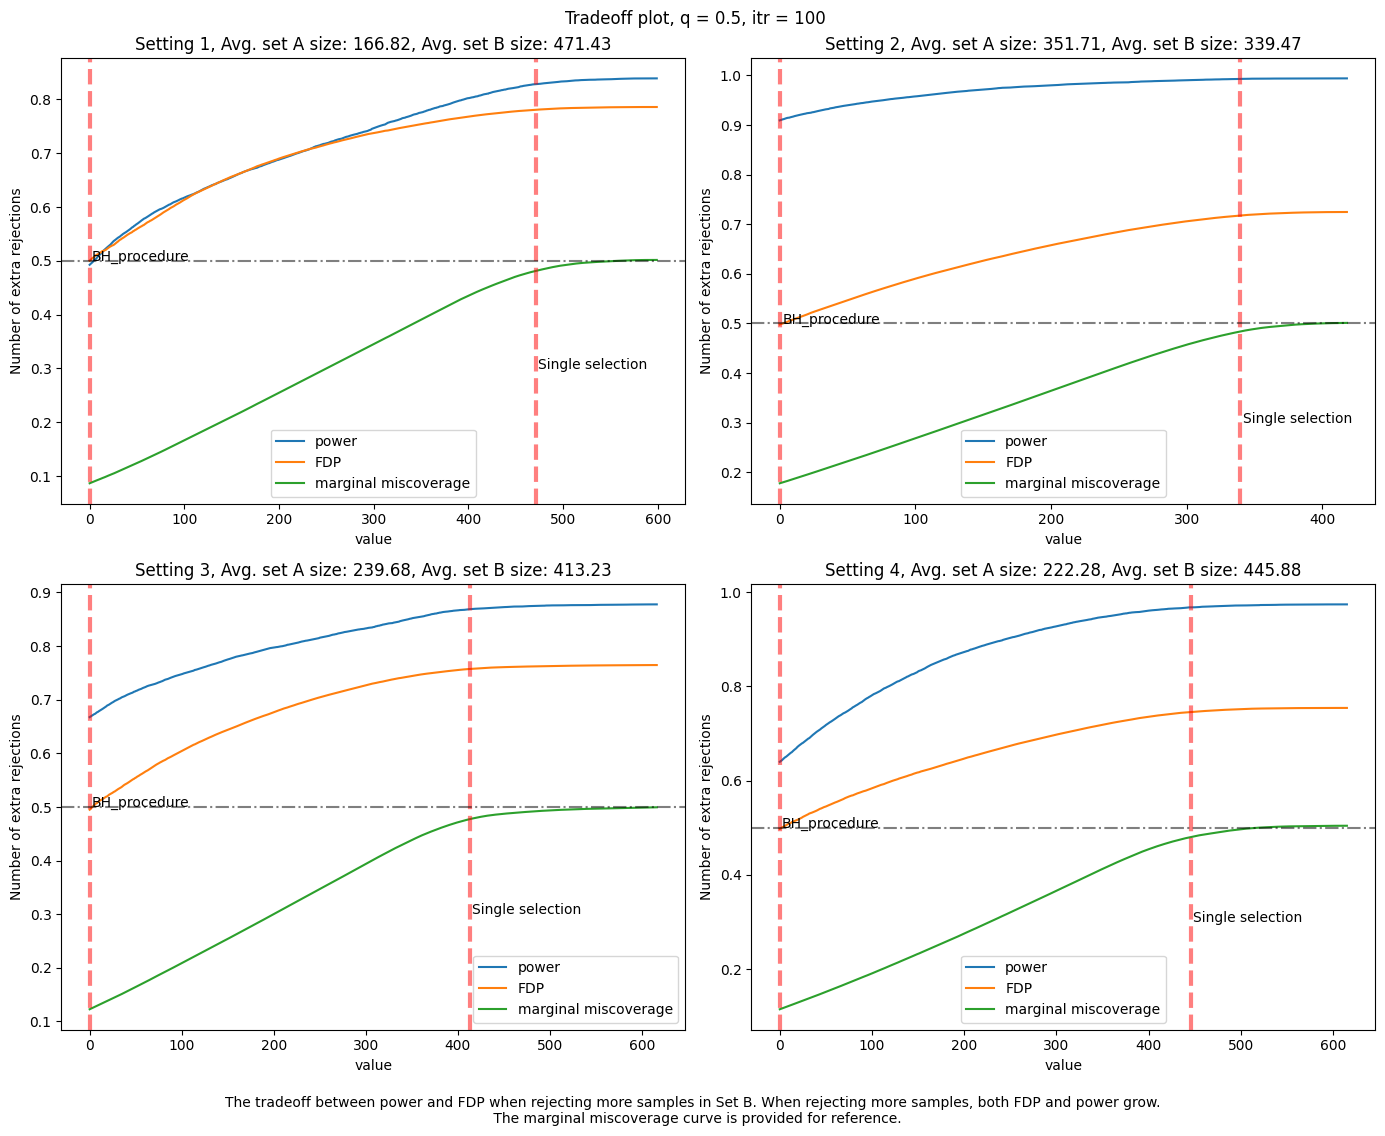

In [298]:
run_and_plot(0.5, False, 100)

### Experiments (PGP)

##### FDR control graph for varying nominal levels

In [15]:
from utility import BH, Bonferroni, SingleSel, RegionSel, gen_data

# threshold = {1: -2.3, 2: 0.1, 5: -0.43, 6: -1.5}  # lower 15% quantile
threshold = {1: 2.3, 2: 4.0, 5: 0.43, 6: 0.6}   # higher 15% quantile

def run(q):
    train = pd.read_csv("data\\PGP_training_disguised.csv")

    n = len(train)
    perm = np.random.permutation(n)
    test = train.iloc[perm[:int(0.1 * n)]]
    calib = train.iloc[perm[int(0.1 * n):int(0.3 * n)]]
    train = train.iloc[perm[int(0.3 * n):]]

    Ytrain, Ycalib, Ytest = train['Act'].to_numpy(), calib['Act'].to_numpy(), test['Act'].to_numpy()
    Xtrain, Xcalib, Xtest = train.drop(columns=['MOLECULE', 'Act']).to_numpy(), calib.drop(columns=['MOLECULE', 'Act']).to_numpy(), test.drop(columns=['MOLECULE', 'Act']).to_numpy()

    lower = -100
    higher = -0.3

    Ytest_orig = Ytest

    Ytrain = 1 * ((lower < Ytrain) & (Ytrain < higher))
    Ycalib = 1 * ((lower < Ycalib) & (Ycalib < higher))
    Ytest = 1 * ((lower < Ytest) & (Ytest < higher))

    rf = RandomForestRegressor(n_estimators=100, max_depth=20, max_features='sqrt')
    rf.fit(Xtrain, Ytrain)

    r_sq = r2_score(Ytest, rf.predict(Xtest))

    calib_scores = Ycalib - rf.predict(Xcalib)          
    calib_scores0 = -rf.predict(Xcalib)                     
    calib_scores_2clip = 1000 * (Ycalib > 0) - rf.predict(Xcalib)   # Ycalib > 0.5 <=> original Ycalib < threshold

    test_scores = -rf.predict(Xtest)

    # selection target is 
    true_reject = sum(Ytest > 0) 
    BH_2clip = BH(calib_scores_2clip, test_scores, q )
    # Single = SingleSel(calib_scores_2clip, test_scores, q )
    Single = RegionSel(calib_scores, test_scores, q )
    
    rest = [i for i in Single if i not in BH_2clip]
    return Ytest, Single, BH_2clip

def eval(Y, rejected, lower, higher):
    true_reject = np.sum((lower < Y) & (Y < higher))
    if len(rejected) == 0:
        fdp = 0
        pcer = 0
        power = 0
    else:
        fdp = np.sum((lower >= Y[rejected]) | (Y[rejected] >= higher)) / len(rejected)
        pcer = np.sum((lower >= Y[rejected]) | (Y[rejected] >= higher)) / len(Y)
        power = np.sum((lower < Y[rejected]) & (Y[rejected] < higher)) / true_reject if true_reject != 0 else 0
    return fdp, pcer, power

In [16]:
import numpy as np
from tqdm import tqdm

def run_and_plot(itr=100):
    q_list = np.linspace(0.01, 0.3, 30)
    s_fdps, s_pcers, s_powers = [], [], []
    b_fdps, b_pcers, b_powers = [], [], []

    for q in tqdm(q_list):
        avg_s_fdp, avg_s_pcer, avg_s_power = 0, 0, 0
        avg_b_fdp, avg_b_pcer, avg_b_power = 0, 0, 0

        for k in range(itr):
            Y, single, bh = run(q)
            s_fdp, s_pcer, s_power = eval(Y, single, 0, 100)
            b_fdp, b_pcer, b_power = eval(Y, bh, 0, 100)

            avg_s_fdp += s_fdp / itr
            avg_s_pcer += s_pcer / itr
            avg_s_power += s_power / itr
            avg_b_fdp += b_fdp / itr
            avg_b_pcer += b_pcer / itr
            avg_b_power += b_power / itr
        s_fdps.append(avg_s_fdp)
        s_pcers.append(avg_s_pcer)
        s_powers.append(avg_s_power)
        b_fdps.append(avg_b_fdp)
        b_pcers.append(avg_b_pcer)
        b_powers.append(avg_b_power)
    fig, axs = plt.subplots(figsize=(12, 8))
    axs.plot(1 - q_list, s_fdps, marker='o', label='fdp')
    axs.plot(1 - q_list, s_pcers, marker='o', label='pcer')
    axs.plot([0.7, 1], [0.3, 0], linestyle='-.', alpha=0.5)
    axs.set_title("PCER vs FDP plot for varying nominal levels")
    axs.set_xlabel("Nominal confidence levels")
    axs.set_ylabel("Realized values")
    fig.legend()
    plt.show()

100%|██████████| 30/30 [22:29<00:00, 44.98s/it]


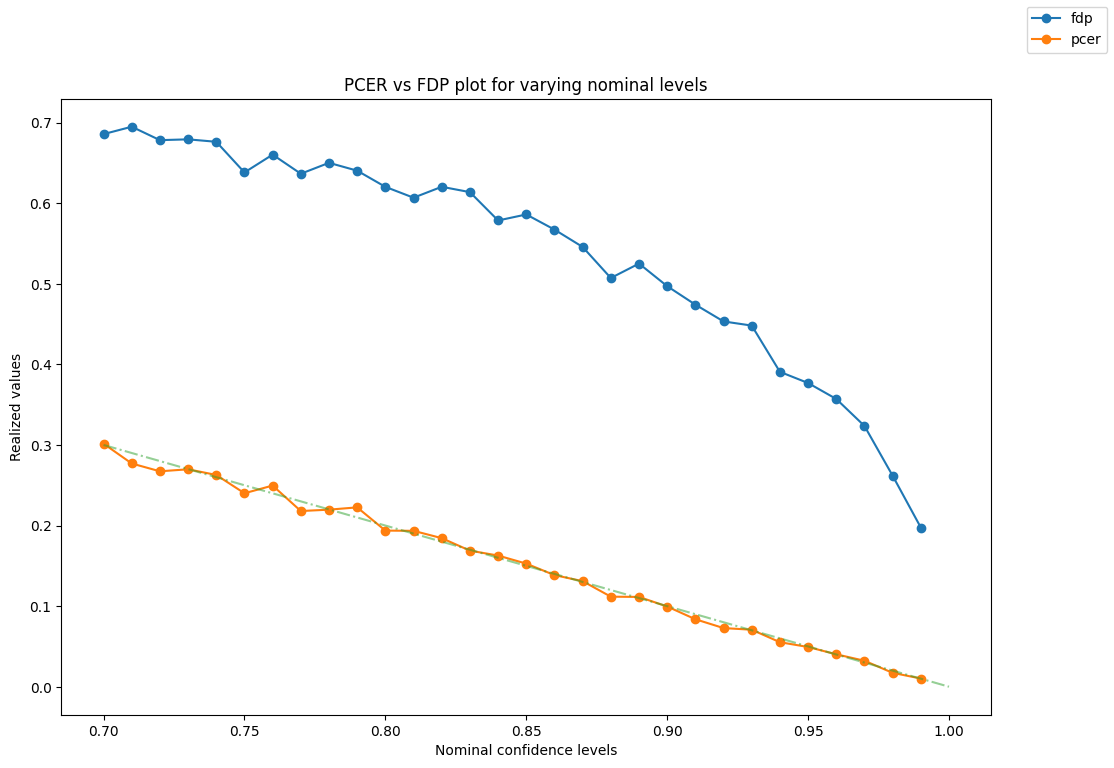

In [17]:
run_and_plot(itr=10)

##### Bonferroni FDR and Power graph for varying nominal levels

In [38]:
from utility import BH, Bonferroni, SingleSel, RegionSel, gen_data

def run(q):
    train = pd.read_csv("data\\PGP_training_disguised.csv")

    n = len(train)
    perm = np.random.permutation(n)
    test = train.iloc[perm[:int(0.1 * n)]]
    calib = train.iloc[perm[int(0.1 * n):int(0.3 * n)]]
    train = train.iloc[perm[int(0.3 * n):]]

    Ytrain, Ycalib, Ytest = train['Act'].to_numpy(), calib['Act'].to_numpy(), test['Act'].to_numpy()
    Xtrain, Xcalib, Xtest = train.drop(columns=['MOLECULE', 'Act']).to_numpy(), calib.drop(columns=['MOLECULE', 'Act']).to_numpy(), test.drop(columns=['MOLECULE', 'Act']).to_numpy()

    lower = -100
    higher = -0.3

    Ytest_orig = Ytest

    Ytrain = 1 * ((lower < Ytrain) & (Ytrain < higher))
    Ycalib = 1 * ((lower < Ycalib) & (Ycalib < higher))
    Ytest = 1 * ((lower < Ytest) & (Ytest < higher))

    rf = RandomForestRegressor(n_estimators=100, max_depth=20, max_features='sqrt')
    rf.fit(Xtrain, Ytrain)

    r_sq = r2_score(Ytest, rf.predict(Xtest))

    calib_scores = Ycalib - rf.predict(Xcalib)          
    calib_scores0 = -rf.predict(Xcalib)                     
    calib_scores_2clip = 1000 * (Ycalib > 0) - rf.predict(Xcalib)   # Ycalib > 0.5 <=> original Ycalib < threshold

    test_scores = -rf.predict(Xtest)

    # selection target is 
    true_reject = sum(Ytest > 0) 
    BH_2clip = BH(calib_scores_2clip, test_scores, q )
    # Single = SingleSel(calib_scores_2clip, test_scores, q )
    bonf = Bonferroni(calib_scores, test_scores, q )
    
    return Ytest, bonf, BH_2clip

def eval(Y, rejected, lower, higher):
    true_reject = np.sum((lower < Y) & (Y < higher))
    if len(rejected) == 0:
        fdp = 0
        pcer = 0
        power = 0
    else:
        fdp = np.sum((lower >= Y[rejected]) | (Y[rejected] >= higher)) / len(rejected)
        pcer = np.sum((lower >= Y[rejected]) | (Y[rejected] >= higher)) / len(Y)
        power = np.sum((lower < Y[rejected]) & (Y[rejected] < higher)) / true_reject if true_reject != 0 else 0
    return fdp, pcer, power

In [39]:
import numpy as np
from tqdm import tqdm

def run_and_plot(itr=100):
    q_list = np.linspace(0.1, 0.5, 20)
    s_fdps, s_pcers, s_powers = [], [], []
    b_fdps, b_pcers, b_powers = [], [], []

    for q in tqdm(q_list):
        avg_s_fdp, avg_s_pcer, avg_s_power = 0, 0, 0
        avg_b_fdp, avg_b_pcer, avg_b_power = 0, 0, 0

        for k in range(itr):
            Y, bonf, bh = run(q)
            s_fdp, s_pcer, s_power = eval(Y, bonf, 0, 100)
            b_fdp, b_pcer, b_power = eval(Y, bh, 0, 100)

            avg_s_fdp += s_fdp / itr
            avg_s_pcer += s_pcer / itr
            avg_s_power += s_power / itr
            avg_b_fdp += b_fdp / itr
            avg_b_pcer += b_pcer / itr
            avg_b_power += b_power / itr
        s_fdps.append(avg_s_fdp)
        s_pcers.append(avg_s_pcer)
        s_powers.append(avg_s_power)
        b_fdps.append(avg_b_fdp)
        b_pcers.append(avg_b_pcer)
        b_powers.append(avg_b_power)
    fig, axs = plt.subplots(figsize=(12, 8))
    axs.plot(q_list, s_fdps, marker='o', label='Bonferroni')
    axs.plot(q_list, b_fdps, marker='o', label='BH')
    axs.plot([0.1, 0.5], [0.1, 0.5], linestyle='-.', alpha=0.5)
    axs2 = axs.twinx()
    axs2.bar(q_list, s_powers, width=0.005, alpha=0.4)
    axs2.bar(q_list + 0.005, b_powers, width=0.005, alpha=0.4)
    axs2.set_ylabel("Power")
    axs.set_title("FDP and Power comparison for Bonferroni and BH")
    axs.set_xlabel("FDR target")
    axs.set_ylabel("Realized FDR")
    fig.legend()
    plt.show()

100%|██████████| 20/20 [11:33<00:00, 34.66s/it]


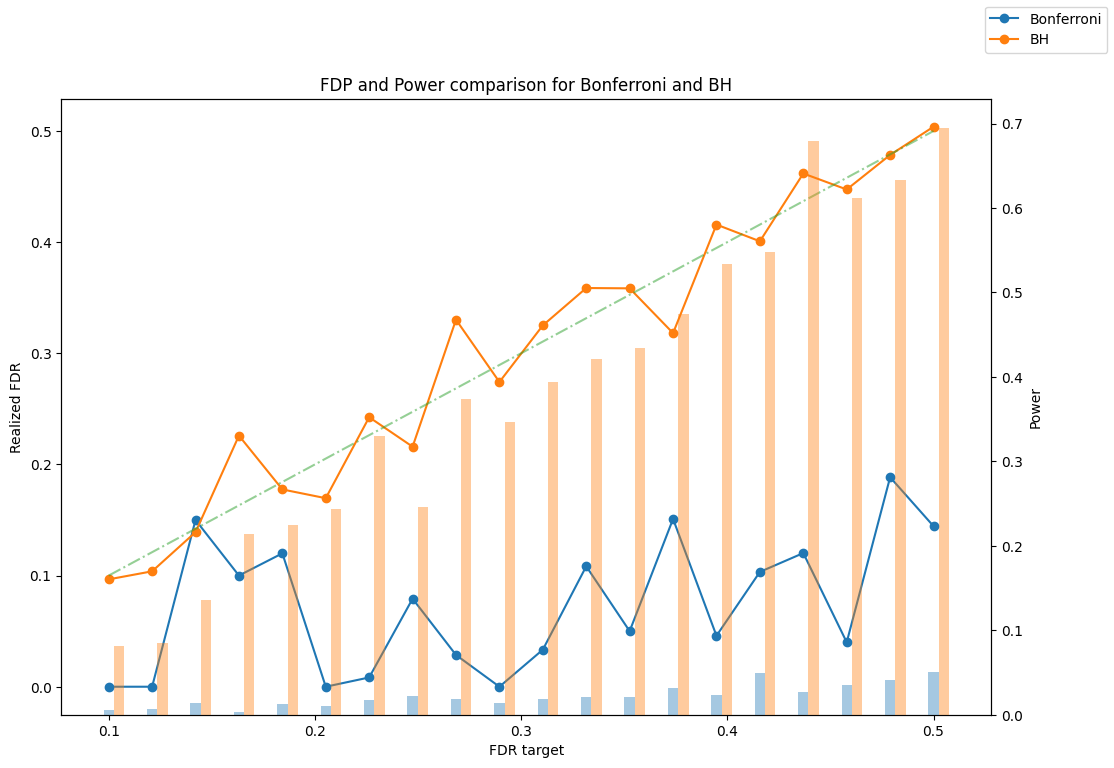

In [43]:
run_and_plot(10)

##### Plot the distribution comparison graph

In [59]:
from utility import BH, Bonferroni, SingleSel

def run(q):
    train = pd.read_csv("data\\PGP_training_disguised.csv")

    n = len(train)
    perm = np.random.permutation(n)
    test = train.iloc[perm[:int(0.1 * n)]]
    calib = train.iloc[perm[int(0.1 * n):int(0.3 * n)]]
    train = train.iloc[perm[int(0.3 * n):]]

    Ytrain, Ycalib, Ytest = train['Act'].to_numpy(), calib['Act'].to_numpy(), test['Act'].to_numpy()
    Xtrain, Xcalib, Xtest = train.drop(columns=['MOLECULE', 'Act']).to_numpy(), calib.drop(columns=['MOLECULE', 'Act']).to_numpy(), test.drop(columns=['MOLECULE', 'Act']).to_numpy()

    lower = -100
    higher = -0.3

    Ytest_orig = Ytest

    Ytrain = 1 * ((lower < Ytrain) & (Ytrain < higher))
    Ycalib = 1 * ((lower < Ycalib) & (Ycalib < higher))
    Ytest = 1 * ((lower < Ytest) & (Ytest < higher))

    rf = RandomForestRegressor(n_estimators=100, max_depth=20, max_features='sqrt')
    rf.fit(Xtrain, Ytrain)

    r_sq = r2_score(Ytest, rf.predict(Xtest))

    calib_scores = Ycalib - rf.predict(Xcalib)          
    calib_scores0 = -rf.predict(Xcalib)                     
    calib_scores_2clip = 1000 * (Ycalib > 0) - rf.predict(Xcalib)   # Ycalib > 0.5 <=> original Ycalib < threshold

    test_scores = -rf.predict(Xtest)

    # selection target is 
    true_reject = sum(Ytest > 0) 
    BH_2clip = BH(calib_scores_2clip, test_scores, q )
    Single = SingleSel(calib_scores_2clip, test_scores, q )
    
    rest = [i for i in Single if i not in BH_2clip]
    return Ytest_orig, BH_2clip, rest

100%|██████████| 100/100 [05:27<00:00,  3.28s/it]


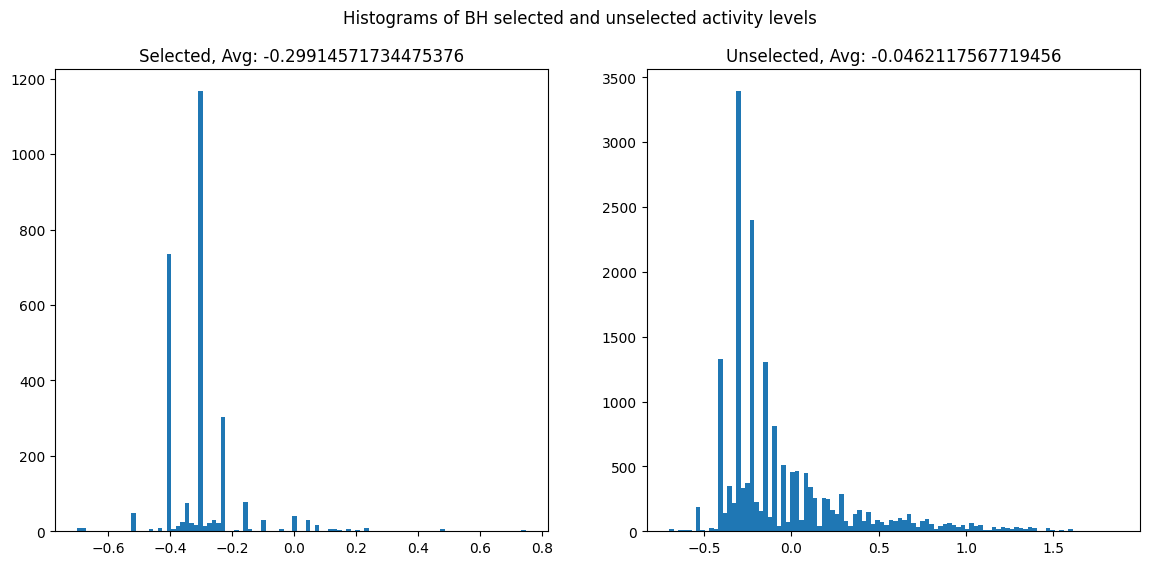

In [37]:
from tqdm import tqdm

BH_2clip_values = []
rest_values = []

q = 0.2

for itr in tqdm(range(100)):
    Ytest_orig, bh, rest = run(q)
    if len(bh):
        BH_2clip_values.extend(Ytest_orig[bh])
    if len(rest):
        rest_values.extend(Ytest_orig[rest])

fig, axs = plt.subplots(ncols=2, figsize=(14,6))
axs[0].hist(BH_2clip_values, bins=100)
axs[0].title.set_text(f'Selected, Avg: {np.mean(BH_2clip_values)}')
axs[1].hist(rest_values, bins=100)
axs[1].title.set_text(f'Unselected, Avg: {np.mean(rest_values)}')

fig.suptitle("Histograms of BH selected and unselected activity levels")
plt.show()

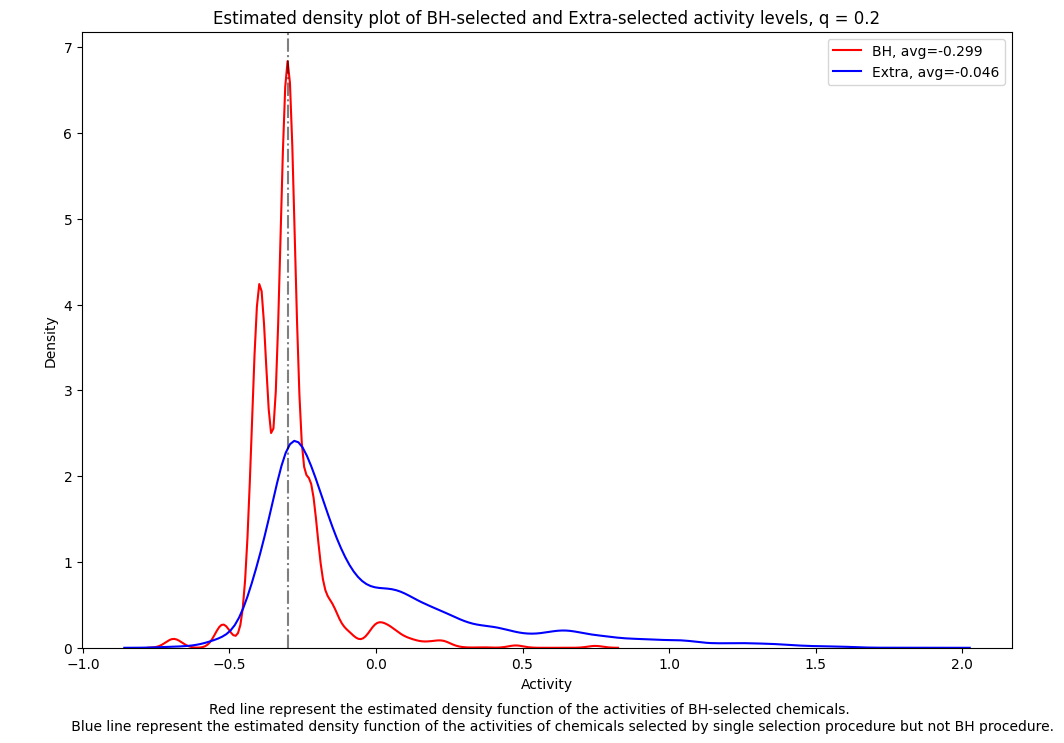

In [60]:
import seaborn as sb

fig = plt.figure(figsize=(12, 8))

plt.title(f"Estimated density plot of BH-selected and Extra-selected activity levels, q = {q}")
sb.kdeplot(BH_2clip_values, color='red')
sb.kdeplot(rest_values, color='blue')
plt.axvline(-0.3, color='black', linestyle='-.', alpha=0.5)
plt.xlabel('Activity')
plt.legend(labels=['BH, avg=-0.299', 'Extra, avg=-0.046'])

plt.figtext(0.5, 0.01, "Red line represent the estimated density function of the activities of BH-selected chemicals. \n \
             Blue line represent the estimated density function of the activities of chemicals selected by single selection procedure but not BH procedure.",
             wrap=True, horizontalalignment='center')
plt.show()

##### Plot the selection tradeoff graph

In [42]:
from utility import BH, Bonferroni, SingleSel

def run(q):
    train = pd.read_csv("data\\PGP_training_disguised.csv")

    n = len(train)
    perm = np.random.permutation(n)
    test = train.iloc[perm[:int(0.1 * n)]]
    calib = train.iloc[perm[int(0.1 * n):int(0.3 * n)]]
    train = train.iloc[perm[int(0.3 * n):]]

    Ytrain, Ycalib, Ytest = train['Act'].to_numpy(), calib['Act'].to_numpy(), test['Act'].to_numpy()
    Xtrain, Xcalib, Xtest = train.drop(columns=['MOLECULE', 'Act']).to_numpy(), calib.drop(columns=['MOLECULE', 'Act']).to_numpy(), test.drop(columns=['MOLECULE', 'Act']).to_numpy()

    lower = -100
    higher = -0.3

    Ytest_orig = Ytest

    Ytrain = 1 * ((lower < Ytrain) & (Ytrain < higher))
    Ycalib = 1 * ((lower < Ycalib) & (Ycalib < higher))
    Ytest = 1 * ((lower < Ytest) & (Ytest < higher))

    rf = RandomForestRegressor(n_estimators=100, max_depth=20, max_features='sqrt')
    rf.fit(Xtrain, Ytrain)

    r_sq = r2_score(Ytest, rf.predict(Xtest))

    calib_scores = Ycalib - rf.predict(Xcalib)          
    calib_scores0 = -rf.predict(Xcalib)                     
    calib_scores_2clip = 1000 * (Ycalib > 0) - rf.predict(Xcalib)   # Ycalib > 0.5 <=> original Ycalib < threshold

    test_scores = -rf.predict(Xtest)

    # selection target is 
    true_reject = sum(Ytest > 0) 
        
    # use clipped scores
    BH_2clip = BH(calib_scores_2clip, test_scores, q, )
    Single = SingleSel(calib_scores_2clip, test_scores, q, )
    
    # if BH_2clip is sorted and Single is sorted, then rest is also sorted based on p-values
    rest = [i for i in Single if i not in BH_2clip]
    
    # start with selecting all BH-selected samples
    selected = BH_2clip
    if len(selected):
        false_sel = np.sum(Ytest[selected] <= 0)
        true_sel = np.sum(Ytest[selected] > 0)
    else:
        false_sel = 0
        true_sel = 0
    nsel = len(selected)

    powers = [true_sel / true_reject if true_reject else 0]
    fdps = [false_sel / nsel if nsel else 0]
    miscoverages = [false_sel / len(Ytest)]

    # now gradually increase the selected samples, and see how power/fdp changes.
    for i in rest:
        nsel += 1
        if Ytest[i] > 0: # another good sel
            true_sel += 1
        else:
            false_sel += 1
        powers.append(true_sel / true_reject if true_reject else 0)
        fdps.append(false_sel / nsel if nsel else 0)
        miscoverages.append(false_sel / len(Ytest))

    return powers, fdps, miscoverages, len(BH_2clip), len(Single)


In [43]:
from tqdm import tqdm 

q = 0.2

base_power = 0
base_fdp = 0
base_misc = 0

largest_diff = 0
power_incr = np.zeros(1000)
fdp_incr = np.zeros(1000)
misc_incr = np.zeros(1000)

bh_lens = 0
single_lens = 0

for itr in tqdm(range(100)):
    powers, fdps, misc, bh_len, single_len = run(q)
    bh_lens += bh_len
    single_lens += single_len
    base_power += powers[0]
    base_fdp += fdps[0]
    base_misc += misc[0]

    largest_diff = max(largest_diff, len(fdps))
    for i in range(len(powers) - 1):
        power_incr[i] += powers[i+1] - powers[i]
        fdp_incr[i] += fdps[i+1] - fdps[i]
        misc_incr[i] += misc[i+1] - misc[i]

power_incr /= 100
fdp_incr /= 100
misc_incr /= 100
base_power /= 100
base_fdp /= 100
base_misc /= 100
bh_lens /= 100
single_lens /= 100

print(bh_lens, single_lens)

100%|██████████| 100/100 [06:49<00:00,  4.10s/it]

25.85 205.49


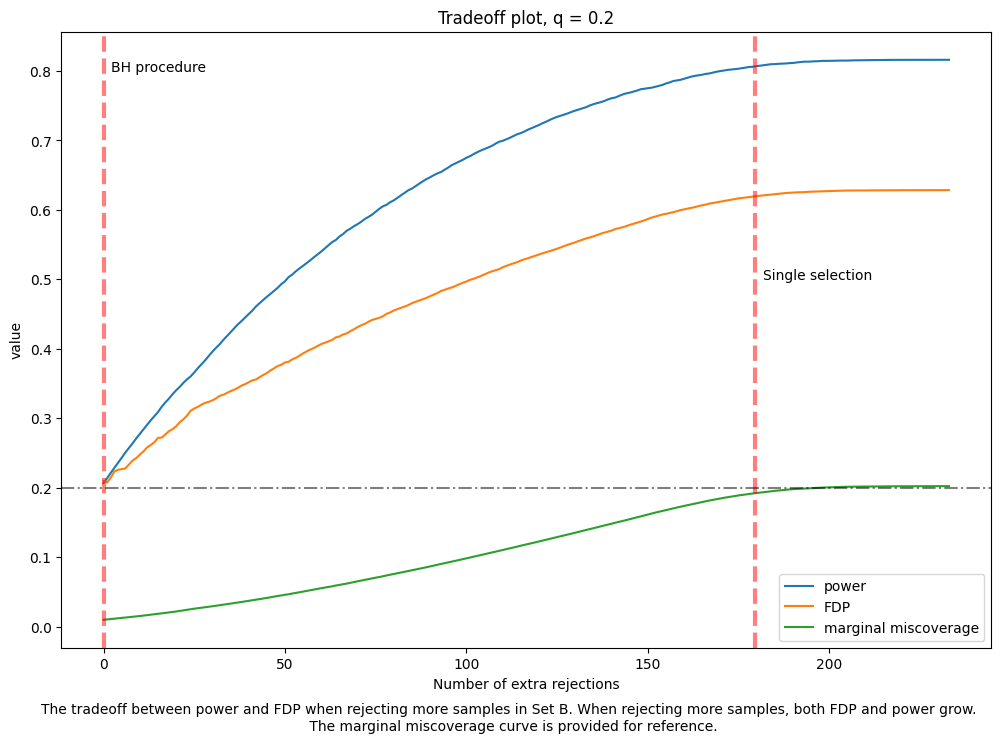

In [70]:
powers = np.zeros(largest_diff+1)
fdps = np.zeros(largest_diff+1)
misc = np.zeros(largest_diff+1)
powers[0] = base_power
fdps[0] = base_fdp
misc[0] = base_misc
for i in range(1, largest_diff+1):
    powers[i] = powers[i-1] + power_incr[i-1]
    fdps[i] = fdps[i-1] + fdp_incr[i-1]
    misc[i] = misc[i-1] + misc_incr[i-1]

fig = plt.figure(figsize=(12, 8))
plt.plot(powers, label='power')
plt.plot(fdps, label='FDP')
plt.plot(misc, label='marginal miscoverage')
plt.axvline((single_lens - bh_lens), linestyle='--', color='red', alpha=0.5, linewidth=3)
plt.axvline(0, linestyle='--', color='red', alpha=0.5, linewidth=3)
plt.axhline(q, linestyle='-.', alpha=0.5, color='black')
plt.title(f'Tradeoff plot, q = {q}')
plt.xlabel('Number of extra rejections')
plt.ylabel('value')
plt.text(2, 0.8, "BH procedure")
plt.text((single_lens - bh_lens) + 2, 0.5, "Single selection")
plt.figtext(0.5, 0.01, "The tradeoff between power and FDP when rejecting more samples in Set B. When rejecting more samples, both FDP and power grow. \n The marginal miscoverage curve is provided for reference.",
             wrap=True, horizontalalignment='center')
plt.legend()
plt.show()

##### Investigate the distribution of nonconformity scores

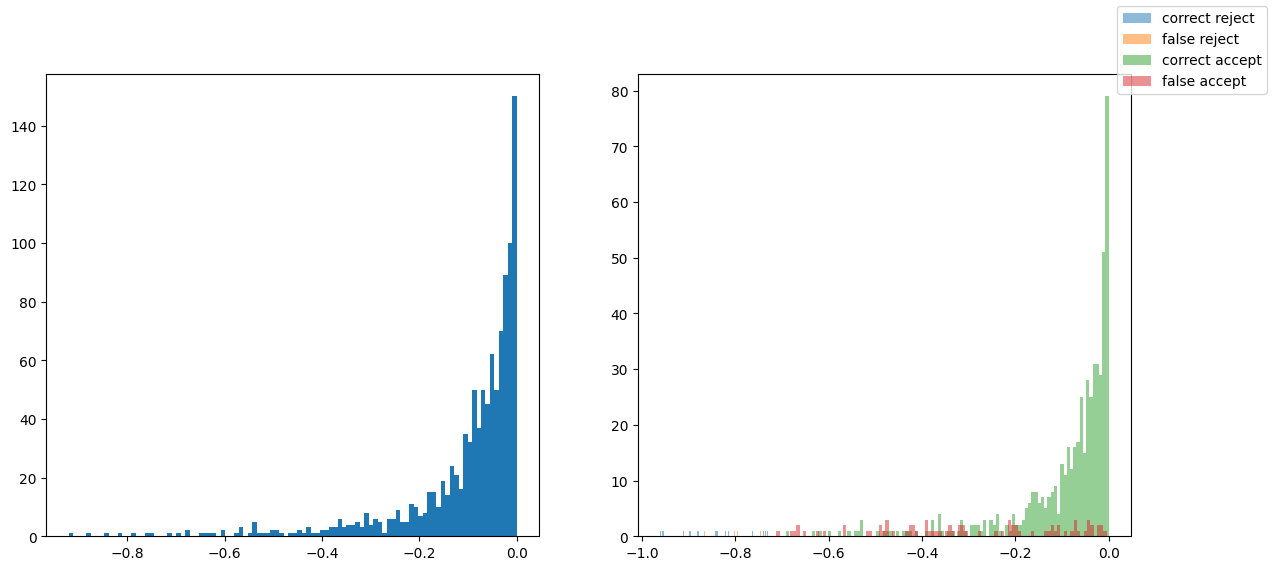

In [25]:
def intersect(l1, l2):
    return [value for value in l1 if value in l2]

BH_2clip_c = [i for i in range(len(Ytest)) if i not in BH_2clip]

reject = np.where(Ytest > 0)[0]
notreject = np.where(Ytest <= 0)[0]

correct_reject = intersect(BH_2clip, reject)
false_reject = intersect(BH_2clip, notreject)
correct_accept = intersect(BH_2clip_c, notreject)
false_accept = intersect(BH_2clip_c, reject)

fig, axs = plt.subplots(ncols=2, figsize=(14, 6))
axs[0].hist(calib_scores_2clip[calib_scores_2clip < 10], bins=100)

axs[1].hist(test_scores[correct_reject], bins=100, alpha=0.5, label='correct reject')
axs[1].hist(test_scores[false_reject], bins=100, alpha=0.5, label='false reject')
axs[1].hist(test_scores[correct_accept], bins=100, alpha=0.5, label='correct accept')
axs[1].hist(test_scores[false_accept], bins=100, alpha=0.5, label='false accept')
fig.legend()
plt.show()

### Versus Sheridan et al. (2004), Sheridan (2012)

In [72]:
# use dice similarity
from sklearn.metrics.pairwise import cosine_similarity

''' 
Takes a fingerprint (might be non-binary), calculate the maximum generalized Dice similarity between it and a set of fingerprints.
'''
def dice_sim(f, set_of_f):
    f = np.array(f)
    set_of_f = np.array(set_of_f) 

    min_count = np.minimum(f, set_of_f).sum(axis=1) * 2
    sum_count = f.sum() + set_of_f.sum(axis=1)
    sum_count[sum_count == 0] = 1
    return np.max(min_count / sum_count)

In [73]:
from sklearn.model_selection import train_test_split

PGP_data = pd.read_csv("data\\PGP_training_disguised.csv")
total_Y = PGP_data['Act'].to_numpy()
total_X = PGP_data.drop(columns=['MOLECULE', 'Act']).to_numpy()

Xtc, Xtest, Ytc, Ytest = train_test_split(total_X, total_Y, test_size=0.3, shuffle=True) # tc: train and calib
# use this test set (Xtest, Ytest), for both methods for a fair comparison

In [6]:
# perform sheridans method: first get data to generate error curve

import numpy as np
from tqdm import tqdm
from sklearn.metrics import root_mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from multiprocessing import Pool

def getrmse():
    Xtrain, Xcalib, Ytrain, Ycalib = train_test_split(Xtc, Ytc, train_size=0.3, shuffle=True)
    rf = RandomForestRegressor(n_estimators=100, max_depth=20, max_features='sqrt')
    rf.fit(Xtrain, Ytrain)

    Ypred = rf.predict(Xcalib)
    all_Ypred = np.column_stack([tree.predict(Xcalib) for tree in rf.estimators_])
    Ypredvar = np.var(all_Ypred, axis=1)
    RMSE = np.absolute(Ycalib - Ypred)
    sim_nearest = np.array([dice_sim(x, Xtrain) for x in Xcalib])

    RMSE_tmp_df = pd.DataFrame({"dice": sim_nearest, "pred": Ypred, "var": Ypredvar, "RMSE": RMSE})
    return RMSE_tmp_df

REPEAT_RMSE = 10

results = []
for k in tqdm(range(REPEAT_RMSE)):
    results.append(getrmse())

RMSE_df = pd.concat(results, ignore_index=True)

100%|██████████| 10/10 [15:41<00:00, 94.20s/it]


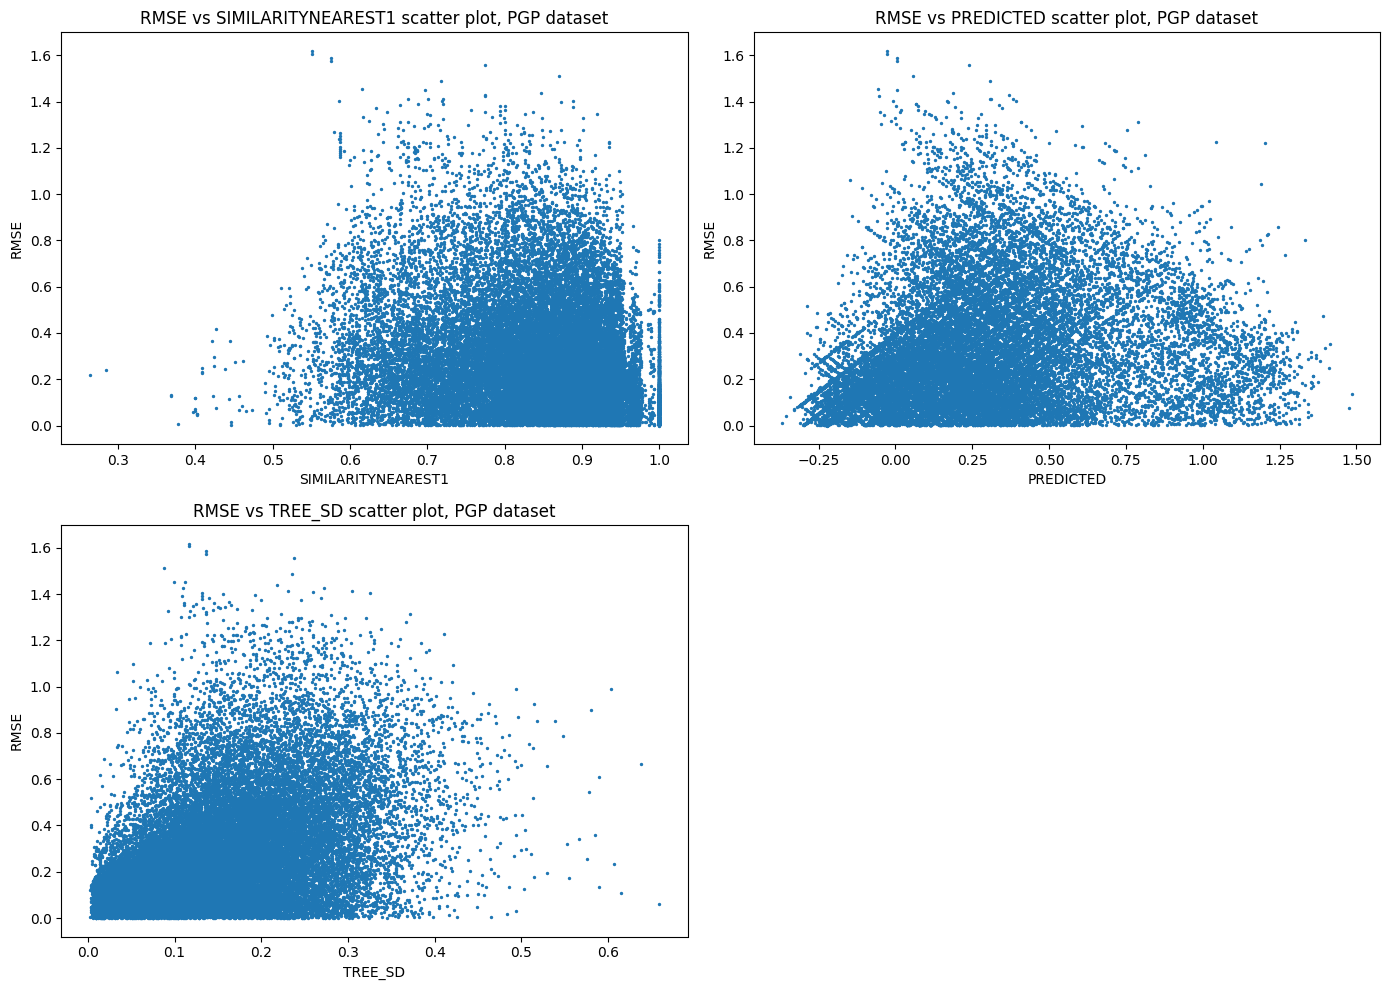

In [74]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(14, 10))

axs[0][0].scatter(RMSE_df['dice'], RMSE_df['RMSE'], s=2)
axs[0][0].set_title("RMSE vs SIMILARITYNEAREST1 scatter plot, PGP dataset")
axs[0][0].set_xlabel("SIMILARITYNEAREST1")
axs[0][0].set_ylabel("RMSE")

axs[0][1].scatter(RMSE_df['pred'], RMSE_df['RMSE'], s=2)
axs[0][1].set_title("RMSE vs PREDICTED scatter plot, PGP dataset")
axs[0][1].set_xlabel("PREDICTED")
axs[0][1].set_ylabel("RMSE")

axs[1][0].scatter(RMSE_df['var'], RMSE_df['RMSE'], s=2)
axs[1][0].set_title("RMSE vs TREE_SD scatter plot, PGP dataset")
axs[1][0].set_xlabel("TREE_SD")
axs[1][0].set_ylabel("RMSE")

fig.delaxes(axs[1][1])
fig.tight_layout()
plt.show()

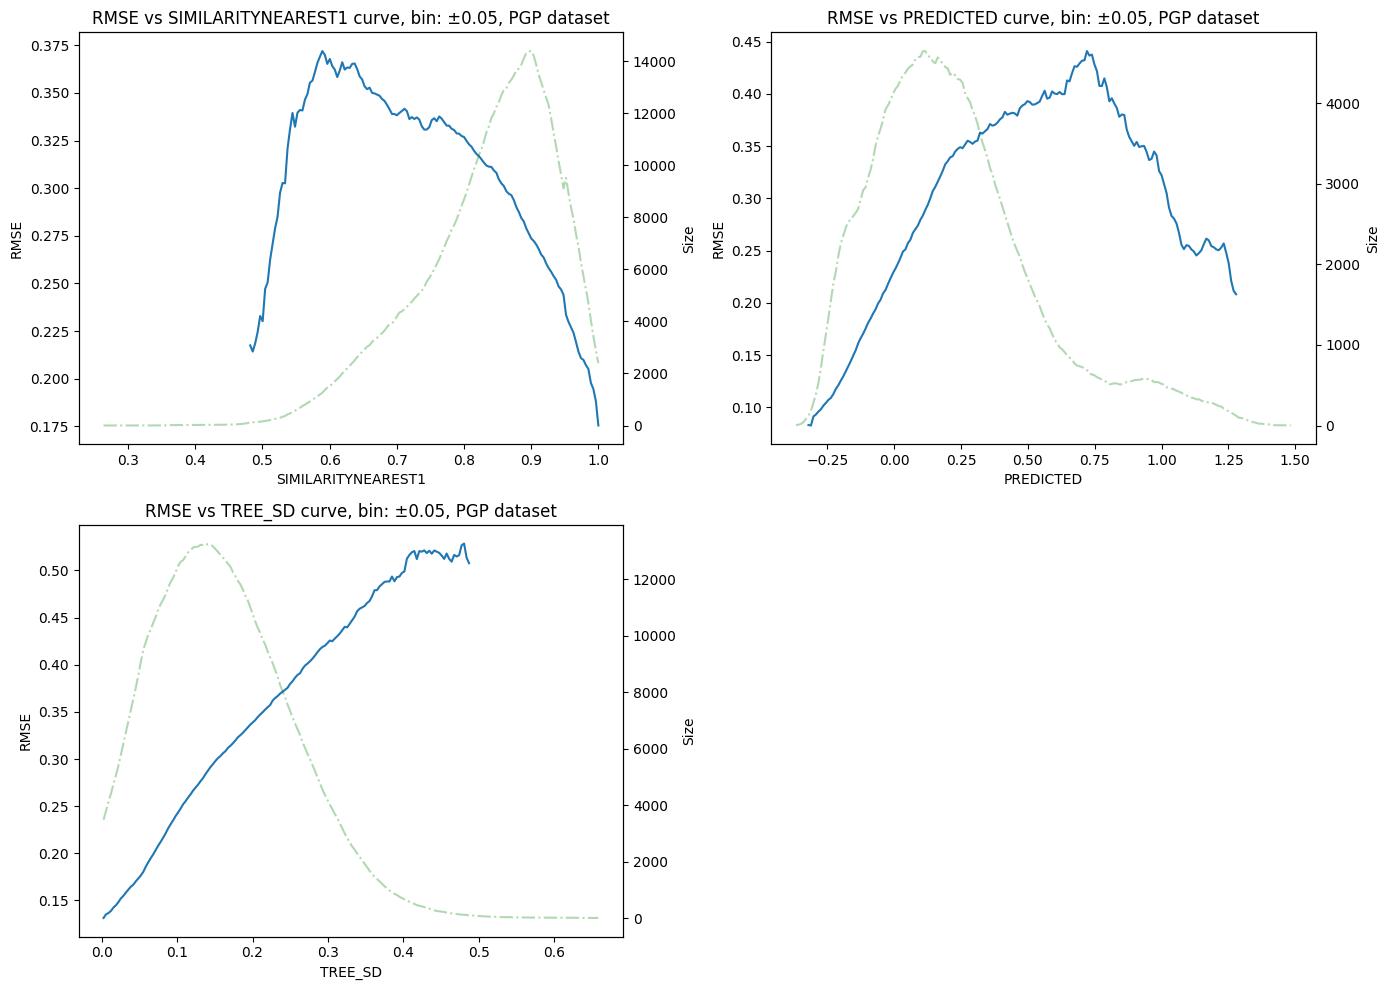

In [83]:
# the two similarities are similar. We will use dice
# now, smoothen it (using bins) and then create an error curve
# bin size: +- 0.05

fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(14, 10))

xlist = np.linspace(RMSE_df["dice"].min(), RMSE_df["dice"].max(), 200) # sim
ylist = []
sizelist = []
for x in xlist:
    low, high = x - 0.05, x + 0.05
    filtered_RMSE_df = RMSE_df[(low <= RMSE_df["dice"]) & (RMSE_df["dice"] <= high)]
    y_avg = filtered_RMSE_df["RMSE"].mean()
    ylist.append(y_avg)
    sizelist.append(len(filtered_RMSE_df))
ylist = np.array(ylist)
sizelist = np.array(sizelist)

axs[0][0].plot(xlist[sizelist > 100], ylist[sizelist > 100], label='RMSE')
axs[0][0].set_ylabel("RMSE")
axs[0][0].set_xlabel("SIMILARITYNEAREST1")
axs[0][0].set_title(f"RMSE vs SIMILARITYNEAREST1 curve, bin: ±0.05, PGP dataset")
axs2 = axs[0][0].twinx()
axs2.plot(xlist, sizelist, linestyle='-.', color='green', alpha=0.3, label='values in bin')
axs2.set_ylabel("Size")

xlist = np.linspace(RMSE_df["pred"].min(), RMSE_df["pred"].max(), 200) # sim
ylist = []
sizelist = []
for x in xlist:
    low, high = x - 0.05, x + 0.05
    filtered_RMSE_df = RMSE_df[(low <= RMSE_df["pred"]) & (RMSE_df["pred"] <= high)]
    y_avg = filtered_RMSE_df["RMSE"].mean()
    ylist.append(y_avg)
    sizelist.append(len(filtered_RMSE_df))
ylist = np.array(ylist)
sizelist = np.array(sizelist)

axs[0][1].plot(xlist[sizelist > 100], ylist[sizelist > 100], label='RMSE')
axs[0][1].set_ylabel("RMSE")
axs[0][1].set_xlabel("PREDICTED")
axs[0][1].set_title(f"RMSE vs PREDICTED curve, bin: ±0.05, PGP dataset")
axs2 = axs[0][1].twinx()
axs2.plot(xlist, sizelist, linestyle='-.', color='green', alpha=0.3, label='values in bin')
axs2.set_ylabel("Size")

xlist = np.linspace(RMSE_df["var"].min(), RMSE_df["var"].max(), 200) # sim
ylist = []
sizelist = []
for x in xlist:
    low, high = x - 0.05, x + 0.05
    filtered_RMSE_df = RMSE_df[(low <= RMSE_df["var"]) & (RMSE_df["var"] <= high)]
    y_avg = filtered_RMSE_df["RMSE"].mean()
    ylist.append(y_avg)
    sizelist.append(len(filtered_RMSE_df))
ylist = np.array(ylist)
sizelist = np.array(sizelist)

axs[1][0].plot(xlist[sizelist > 100], ylist[sizelist > 100], label='RMSE')
axs[1][0].set_ylabel("RMSE")
axs[1][0].set_xlabel("TREE_SD")
axs[1][0].set_title(f"RMSE vs TREE_SD curve, bin: ±0.05, PGP dataset")
axs2 = axs[1][0].twinx()
axs2.plot(xlist, sizelist, linestyle='-.', color='green', alpha=0.3, label='values in bin')
axs2.set_ylabel("Size")

fig.delaxes(axs[1][1])
fig.tight_layout()
plt.show()

In [75]:
def eval(Y, rejected, lower, higher):
    true_reject = np.sum((lower < Y) & (Y < higher))
    if len(rejected) == 0:
        fdp = 0
        pcer = 0
        power = 0
    else:
        fdp = np.sum((lower >= Y[rejected]) | (Y[rejected] >= higher)) / len(rejected)
        pcer = np.sum((lower >= Y[rejected]) | (Y[rejected] >= higher)) / len(Y)
        power = np.sum((lower < Y[rejected]) & (Y[rejected] < higher)) / true_reject if true_reject != 0 else 0
    return fdp, pcer, power

In [76]:
# now, need to make this a decision-making procedure
# assume that the prediction region we build is (y_pred + \epsilon * RMSE_pred, +inf). \epsilon is a free (tradeoff) coefficient.
# later, pick \epsilon according to normal distribution quantiles

Xtrain, _, Ytrain, _ = train_test_split(Xtc, Ytc, train_size=0.3, shuffle=True)
sim_test = np.array([dice_sim(x, Xtrain) for x in tqdm(Xtest)])

rf = RandomForestRegressor(n_estimators=100, max_depth=20, max_features='sqrt')
rf.fit(Xtrain, Ytrain)
Ypred_test = rf.predict(Xtest)

allYpred_test = np.column_stack([tree.predict(Xtest) for tree in rf.estimators_])
var_test = np.var(allYpred_test, axis=1)

100%|██████████| 1920/1920 [00:56<00:00, 34.26it/s]


##### Sheridan et al. (2004) - 1 dimensional bin

In [77]:
# using only 1 bin
rmse_test = []
for s in sim_test:
    filtered_RMSE_df = RMSE_df[(s - 0.05 <= RMSE_df["dice"]) & (RMSE_df["dice"] <= s + 0.05)]
    rmse = filtered_RMSE_df["RMSE"].mean()
    rmse_test.append(rmse)
rmse_test = np.array(rmse_test)

In [78]:
from scipy.stats import norm

# miscoverage: 0.01 to 0.5
misc = np.linspace(0.01, 0.99, 200)
alphas = 1 - misc  # confidence level

eps = [norm.ppf(alpha) for alpha in alphas] # positive
fdps_04, pcers_04, powers_04 = np.zeros(200), np.zeros(200), np.zeros(200)

itr = 10
for k in tqdm(range(itr)):
    # repartition data and fit
    rf = RandomForestRegressor(n_estimators=100, max_depth=20, max_features='sqrt')
    Xtrain, Xcalib, Ytrain, Ycalib = train_test_split(Xtc, Ytc, train_size=0.3, shuffle=True)
    rf.fit(Xtrain, Ytrain)
    Ypred_test = rf.predict(Xtest)

    for i, ep in enumerate(eps):
        # build (-inf, Ypred + ep * rmse), alpha% confidence interval
        sheridan_04 = [j for j in range(len(Ypred_test)) if Ypred_test[j] + ep * rmse_test[j] <= -0.3]
        fdp, pcer, power = eval(Ytest, sheridan_04, -100, -0.3)
        fdps_04[i] += fdp / itr
        pcers_04[i] += pcer / itr
        powers_04[i] += power / itr

100%|██████████| 10/10 [00:09<00:00,  1.03it/s]


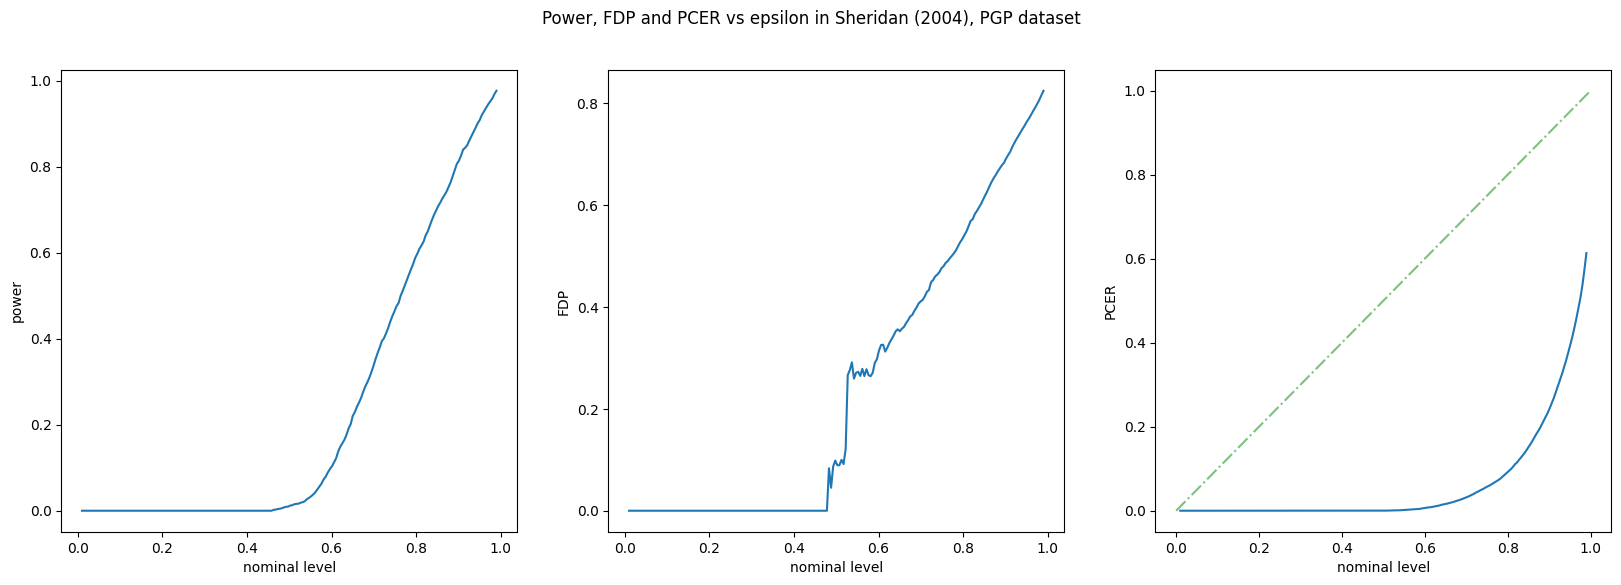

In [81]:
fig, axs = plt.subplots(ncols=3, figsize=(20, 6))

fig.suptitle("Power, FDP and PCER vs epsilon in Sheridan (2004), PGP dataset")
axs[0].plot(1 - alphas, powers_04)
axs[0].set_xlabel("nominal level")
axs[0].set_ylabel("power")
axs[1].plot(1 - alphas, fdps_04)
axs[1].set_xlabel("nominal level")
axs[1].set_ylabel("FDP")
axs[2].plot(1 - alphas, pcers_04)
axs[2].plot([0, 1], [0, 1], color='green', linestyle='-.', alpha=0.5)
axs[2].set_xlabel("nominal level")
axs[2].set_ylabel("PCER")
plt.show()

##### Sheridan (2012) - 3 dimensional bin

In [53]:
# using 3 bin
rmse_test = []
for s, p, v in zip(sim_test, Ypred_test, var_test):
    filtered_RMSE_df = RMSE_df[(s - 0.06 <= RMSE_df["dice"]) & (RMSE_df["dice"] <= s + 0.06) & 
                               (p - 0.06 <= RMSE_df["pred"]) & (RMSE_df["pred"] <= p + 0.06) &
                               (v - 0.06 <= RMSE_df["var"]) & (RMSE_df["var"] <= v + 0.06)]
    rmse = filtered_RMSE_df["RMSE"].mean()
    rmse_test.append(rmse)
rmse_test = np.array(rmse_test)

In [54]:
from scipy.stats import norm

# miscoverage: 0.01 to 0.5
misc = np.linspace(0.01, 0.99, 200)
alphas = 1 - misc  # confidence level

eps = [norm.ppf(alpha) for alpha in alphas] # positive
fdps_12, pcers_12, powers_12 = np.zeros(200), np.zeros(200), np.zeros(200)

itr = 10
for k in tqdm(range(itr)):
    # repartition data and fit
    rf = RandomForestRegressor(n_estimators=100, max_depth=20, max_features='sqrt')
    Xtrain, Xcalib, Ytrain, Ycalib = train_test_split(Xtc, Ytc, train_size=0.3, shuffle=True)
    rf.fit(Xtrain, Ytrain)
    Ypred_test = rf.predict(Xtest)

    for i, ep in enumerate(eps):
        # build (-inf, Ypred + ep * rmse), alpha% confidence interval
        sheridan_12 = [j for j in range(len(Ypred_test)) if Ypred_test[j] + ep * rmse_test[j] <= -0.3]
        fdp, pcer, power = eval(Ytest, sheridan_12, -100, -0.3)
        fdps_12[i] += fdp / itr
        pcers_12[i] += pcer / itr
        powers_12[i] += power / itr

100%|██████████| 10/10 [00:11<00:00,  1.20s/it]


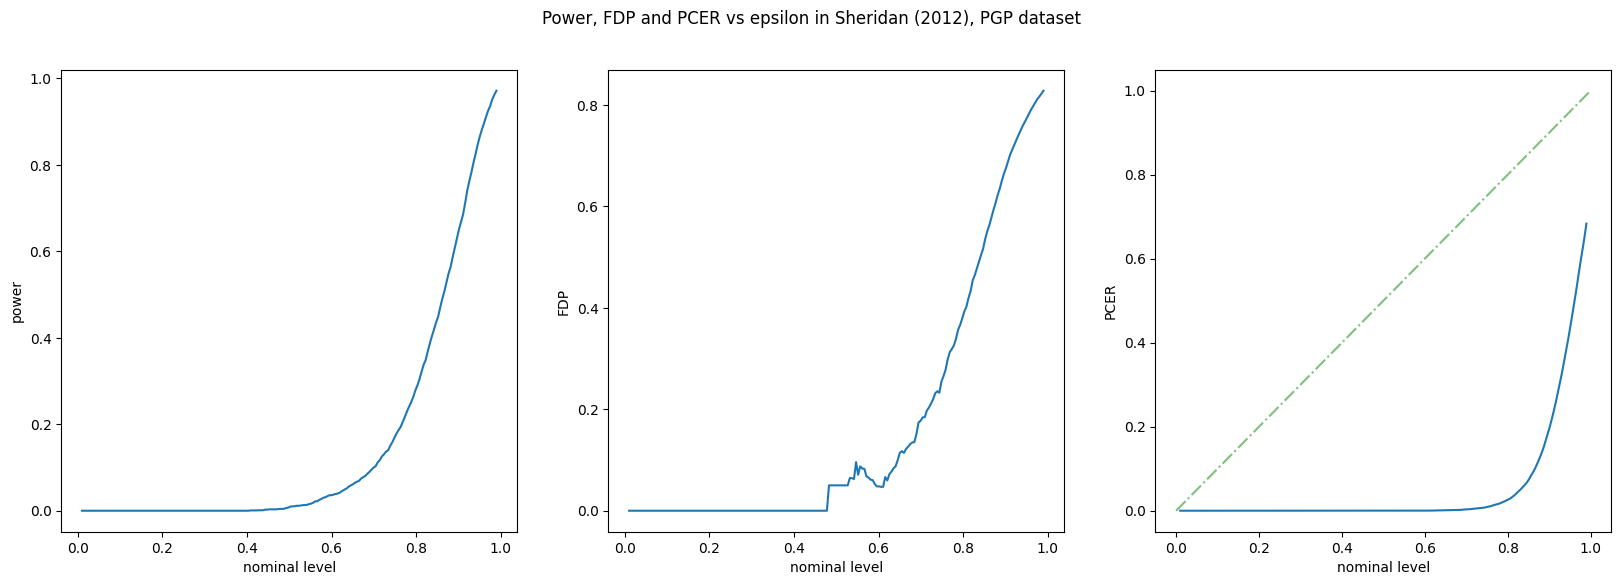

In [55]:
fig, axs = plt.subplots(ncols=3, figsize=(20, 6))

fig.suptitle("Power, FDP and PCER vs epsilon in Sheridan (2012), PGP dataset")
axs[0].plot(1 - alphas, powers_12)
axs[0].set_xlabel("nominal level")
axs[0].set_ylabel("power")
axs[1].plot(1 - alphas, fdps_12)
axs[1].set_xlabel("nominal level")
axs[1].set_ylabel("FDP")
axs[2].plot(1 - alphas, pcers_12)
axs[2].plot([0, 1], [0, 1], color='green', linestyle='-.', alpha=0.5)
axs[2].set_xlabel("nominal level")
axs[2].set_ylabel("PCER")
plt.show()

##### Conformal Selection

In [70]:
# Versus Conformal selection:
from utility import BH
from sklearn.ensemble import RandomForestRegressor
from tqdm import tqdm

fdp_nominals = np.linspace(0.01, 0.99, 200)
fdps_cs, pcers_cs, powers_cs = np.zeros(200), np.zeros(200), np.zeros(200)

lower, higher = -100, -0.3

train = pd.read_csv("data\\PGP_training_disguised.csv")

n = len(train)
perm = np.random.permutation(n)
test = train.iloc[perm[:int(0.3 * n)]]
calib = train.iloc[perm[int(0.3 * n):int(0.5 * n)]]
train = train.iloc[perm[int(0.5 * n):]]

Ytrain, Ycalib, Ytest = train['Act'].to_numpy(), calib['Act'].to_numpy(), test['Act'].to_numpy()
Xtrain, Xcalib, Xtest = train.drop(columns=['MOLECULE', 'Act']).to_numpy(), calib.drop(columns=['MOLECULE', 'Act']).to_numpy(), test.drop(columns=['MOLECULE', 'Act']).to_numpy()

Yorig = Ytest
Ytrain_01 = 1 * ((lower < Ytrain) & (Ytrain < higher))
Ycalib_01 = 1 * ((lower < Ycalib) & (Ycalib < higher))
Ytest_01 = 1 * ((lower < Ytest) & (Ytest < higher))

itr = 10

for k in tqdm(range(itr)):
    rf = RandomForestRegressor(n_estimators=100, max_depth=20, max_features='sqrt')
    rf.fit(Xtrain, Ytrain_01)

    for i, fdp_nominal in enumerate(fdp_nominals):
        calib_scores_2clip = 1000 * (Ycalib_01 > 0) - rf.predict(Xcalib)   # Ycalib > 0.5 <=> original Ycalib < threshold
        test_scores = -rf.predict(Xtest)
        BH_2clip = BH(calib_scores_2clip, test_scores, fdp_nominal )
        fdp, pcer, power = eval(Ytest, BH_2clip, -100, -0.3)
        fdps_cs[i] += fdp / itr
        pcers_cs[i] += pcer / itr
        powers_cs[i] += power / itr

100%|██████████| 10/10 [03:29<00:00, 20.96s/it]


##### Comparison

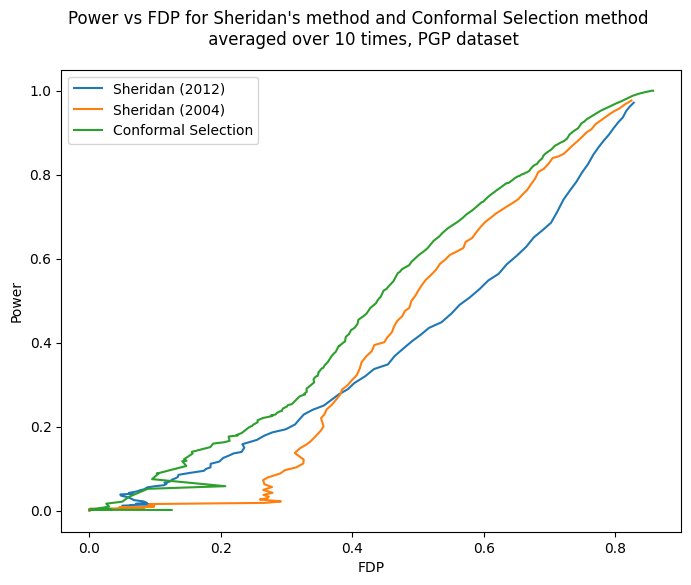

In [80]:
fig, axs = plt.subplots(figsize=(8, 6))

fig.suptitle("Power vs FDP for Sheridan's method and Conformal Selection method \n averaged over 10 times, PGP dataset")
axs.plot(fdps_12, powers_12, label='Sheridan (2012)')
axs.plot(fdps_04, powers_04, label='Sheridan (2004)')
axs.plot(fdps_cs, powers_cs, label='Conformal Selection')
axs.set_xlabel("FDP")
axs.set_ylabel("Power")
plt.legend()
plt.show()